# The new idea

We will have a thing that selects the seeds first according to their values here

prime number rule
multiples of 2, will be shade loving, those not are not
multiples of 3, will be border suitable, those not are not

In [58]:
import numpy as np
import gymnasium as gym
from gymnasium import spaces
import random
from perlin_noise import PerlinNoise
from scipy.spatial.distance import cdist
import cv2
import matplotlib.pyplot as plt
from stable_baselines3.common.env_checker import check_env
from stable_baselines3 import PPO
from stable_baselines3.common.evaluation import evaluate_policy
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import os
import copy
from scipy.ndimage import binary_fill_holes
from scipy.ndimage import label
from scipy.stats import mode

In [59]:
class customSpatialEnv(gym.Env):
    def __init__(self, octave: float, grid_size: tuple = (100, 100), seed: int = None):
            """
            Args:
                octave (float): octave value from range [1-2] for Perlin noise.
                grid_size (tuple): (width, height) of the grid, defaults to (100, 100).
                seed (int): Random seed for reproducibility, defaults to None.
            """
            super(customSpatialEnv, self).__init__()
            self.seed_value = seed
            self.random_state = np.random.RandomState(seed)  # Controlled randomness
            self.grid_size = grid_size
            self.octave = octave
            self.max_attempts = 100000  # Maximum number of attempts
            self.attempt_counter = 0  # Tracks the number of attempts

            self.grid, self.planting_coordinates, self.distances = self._create_environment()

            # Plants: 1 for Tree, 2 for Shrub, 0 for No plant (added)
            self.plants = np.array([0, 1, 2])  # [No Plant, Tree, Shrub]

            # Action space: Use Box for percentage (horizontal, vertical) and plant type (no object, shrub, tree)
            self.action_space = spaces.Box(low=0.0, high=1.0, shape=(3,), dtype=np.float32)

            # Observation space: Dict containing the grid and distances (both horizontal and vertical)
            self.observation_space = spaces.Dict({
                "horizontal_distance": spaces.Box(low=0, high=1, shape=(1,), dtype=np.float32),  # Horizontal distance (left)
                "vertical_distance": spaces.Box(low=0, high=1, shape=(1,), dtype=np.float32),    # Vertical distance (top)
                "tree_proportion": spaces.Box(low=0, high=1, shape=(1,), dtype=np.float32),  # Proportion of trees
                "shrub_proportion": spaces.Box(low=0, high=1, shape=(1,), dtype=np.float32),  # Proportion of shrubs
                "good_tree_spot": spaces.Box(low=0, high=1, shape=(1,), dtype=np.float32),    # Whether the spot is good for planting a tree
                "border_score": spaces.Box(low=0, high=1, shape=(1,), dtype=np.float32)  
            })

            self.num_trees = 0
            self.num_shrubs = 0
            self.planted_tree_positions = []

    def reset(self, seed=None, options=None):
        """
        Reset the environment to its initial state.
        """
        super().reset(seed=seed)  # Ensure that we call the parent class reset for seeding

        # Recreate the environment (reinitialize grid, planting coordinates, and distances)
        self.grid, self.planting_coordinates, self.distances = self._create_environment()
        self.attempt_counter = 0

        # Start with the first planting coordinate if available, otherwise default to [0, 0] for distances
        if len(self.distances) > 0:
            initial_distances = self.distances[0]
        else:
            initial_distances = [0, 0]  # Handle case where no distances are available

        horizontal_distance, vertical_distance = initial_distances[1], initial_distances[0]

        # Ensure the distances are of type float32
        horizontal_distance = np.array([horizontal_distance], dtype=np.float32)
        vertical_distance = np.array([vertical_distance], dtype=np.float32)

        tree_proportion = np.array([0.0], dtype=np.float32)
        shrub_proportion = np.array([0.0], dtype=np.float32)
        good_tree_spot = np.array([0.0], dtype=np.float32)  # Initial boolean flag (False)
        border_score = np.array([0.0], dtype=np.float32)  # Initial boolean flag (False)

        # Initial observation
        return {
            "horizontal_distance": horizontal_distance,
            "vertical_distance": vertical_distance,
            "tree_proportion": tree_proportion,
            "shrub_proportion": shrub_proportion,
            "good_tree_spot": good_tree_spot,
            "border_score": border_score
        }, {}

    def step(self, action):
        """
        The step function takes a single action, which contains three parts:
        - action[0]: horizontal ratio (0-1).
        - action[1]: vertical ratio (0-1).
        - action[2]: plant type selector (0-1), now including No Plant.
        """

        self.attempt_counter += 1

        # Default value for reward (in case of termination due to exceeding max attempts)
        reward = 0  

        # If the number of attempts exceeds max_attempts, terminate the episode with a penalty
        if self.attempt_counter > self.max_attempts:
            reward = -50  # Apply a significant penalty for exceeding maximum attempts
            terminated = True
            return {
                "horizontal_distance": np.array([0.0], dtype=np.float32),
                "vertical_distance": np.array([0.0], dtype=np.float32),
                "tree_proportion": np.array([0.0], dtype=np.float32),
                "shrub_proportion": np.array([0.0], dtype=np.float32),
                "good_tree_spot": np.array([0.0], dtype=np.float32),
                "border_score": np.array([0.0], dtype=np.float32)
            }, reward, terminated, False, {}

        # Unpack the action
        horizontal_ratio = action[0]
        vertical_ratio = action[1]
        plant_type_selector = action[2]

        # Use the horizontal and vertical ratio to find the nearest planting coordinates
        horizontal_target = horizontal_ratio * self.grid_size[1]  # Scale to grid width
        vertical_target = vertical_ratio * self.grid_size[0]  # Scale to grid height

        # Find the closest coordinate to the generated ratio
        coord_index = np.argmin(np.sum(np.abs(self.planting_coordinates - [vertical_target, horizontal_target]), axis=1))

        # Calculate the difference between the target and the selected plantable coordinates
        selected_coord = self.planting_coordinates[coord_index]
        diff = np.linalg.norm(np.array([vertical_target, horizontal_target]) - np.array(selected_coord))

        # Penalize if the distance is greater than 0.5
        if diff > 20:
            reward = 0  # Apply a penalty for selecting a coordinate that is too far from any plantable spot
            terminated = False
            truncated = False
            return {
                "horizontal_distance": np.array([0.0], dtype=np.float32),
                "vertical_distance": np.array([0.0], dtype=np.float32),
                "tree_proportion": np.array([0.0], dtype=np.float32),
                "shrub_proportion": np.array([0.0], dtype=np.float32),
                "good_tree_spot": np.array([0.0], dtype=np.float32),
                "border_score": np.array([0.0], dtype=np.float32)
            }, reward, terminated, truncated, {}

        # Use the plant type selector to determine the plant type
        if plant_type_selector < 0.33:
            plant_type = 0  # No Plant (new option)
        elif plant_type_selector < 0.66:
            plant_type = 1  # Tree
        else:
            plant_type = 2  # Shrub

        # The rest of the planting logic if a valid spot is selected
        planting_coord = self.planting_coordinates[coord_index]

        if self.grid[planting_coord[0], planting_coord[1]] == 125:  # Plantable spot
            # Update the grid with the selected plant type (1: Tree, 2: Shrub)
            self.grid[planting_coord[0], planting_coord[1]] = self.plants[plant_type]

            if len(self.distances) > 0:  # Ensure there are distances to access
                horizontal_distance, vertical_distance = self.distances[min(coord_index, len(self.distances) - 1)]
            else:
                horizontal_distance, vertical_distance = 0.0, 0.0

            # Remove the planted coordinate from the list to avoid planting again in the same spot
            self.planting_coordinates = np.delete(self.planting_coordinates, coord_index, axis=0)
            self.distances = np.delete(self.distances, coord_index, axis=0)

            ####################################################################################
            ### Shrub Proportion and Tree proportion and reward mechanism
            #  Calculate tree and shrub proportions
            total_plants = self.num_trees + self.num_shrubs
            tree_proportion = self.num_trees / total_plants if total_plants > 0 else 0
            shrub_proportion = self.num_shrubs / total_plants if total_plants > 0 else 0
            balance_reward = 0

            # Update tree and shrub counts
            if self.plants[plant_type] == 1:
                self.num_trees += 1
                self.planted_tree_positions.append(planting_coord)  # Track tree positions
                if tree_proportion > 0.2:
                    balance_reward += 2

            elif self.plants[plant_type] == 2:
                self.num_shrubs += 1
                if shrub_proportion > 0.6:
                    balance_reward += 1

            ####################################################################################
            ### Good Tree Spot and Distance mechanism
            good_tree_spot = 1.0  # Assume the spot is good initially
            if plant_type == 1:  # Only check for trees
                for tree_pos in self.planted_tree_positions:
                    if np.array_equal(tree_pos, planting_coord):
                        continue
                    # Calculate the distance between the planted tree and all other trees
                    dist = np.linalg.norm(np.array(planting_coord) - np.array(tree_pos))
                    if dist < 50:  # If any tree is within 50 units, it's not a good spot
                        good_tree_spot = 0.0
                        break
            distance_reward = 0.5
            # Only apply reward for trees (plant_type == 1)
            if self.plants[plant_type] == 1:
                # Apply a reward based on how far the nearest tree is, capped at 50 units
                if good_tree_spot == 1.0:
                    distance_reward = 1  # Normalize reward (closer to 50 = higher reward)
                else:
                    distance_reward = 0

            ####################################################################################

            ### Border Score Segment

            # Retrieve the distances for the selected planting coordinate
            if len(self.distances) > 0:
                horizontal_distance, vertical_distance = self.distances[min(coord_index, len(self.distances) - 1)]
            else:
                horizontal_distance, vertical_distance = 0.0, 0.0

            border_score = 0
            if (abs(horizontal_distance - 0.5) + abs(vertical_distance - 0.5)) > 0.8:
                border_score = 1

            ####################################################################################

            ### Total reward Segment
            reward = 3 * balance_reward + 2 *distance_reward + border_score
            ####################################################################################

            if plant_type == 0:
            # No planting is done, but a small positive reward could be given to avoid excessive no-action use
                reward = 1

        else:
            # Penalize for trying to plant on a non-plantable spot
            reward = -1
            horizontal_distance, vertical_distance = 0.0, 0.0  # Set to zero if invalid action
            tree_proportion = self.num_trees / (self.num_trees + self.num_shrubs) if (self.num_trees + self.num_shrubs) > 0 else 0
            shrub_proportion = self.num_shrubs / (self.num_trees + self.num_shrubs) if (self.num_trees + self.num_shrubs) > 0 else 0
            good_tree_spot = 0.0

        # Ensure the distances are of type float32
        horizontal_distance = np.array([horizontal_distance], dtype=np.float32)
        vertical_distance = np.array([vertical_distance], dtype=np.float32)
        tree_proportion = np.array([tree_proportion], dtype=np.float32)
        shrub_proportion = np.array([shrub_proportion], dtype=np.float32)
        good_tree_spot = np.array([good_tree_spot], dtype=np.float32)
        border_score = np.array([border_score], dtype=np.float32)

        # Observation: the current state of the environment (grid, distances, and tree/shrub proportions)
        observation = {
            "horizontal_distance": horizontal_distance,
            "vertical_distance": vertical_distance,
            "tree_proportion": tree_proportion,
            "shrub_proportion": shrub_proportion,
            "good_tree_spot": good_tree_spot,
            "border_score": border_score
        }

        # Check if the episode should end (plant all possible spots)
        terminated = len(self.planting_coordinates) == 0

        # Truncated remains False
        truncated = False

        info = {
            'diff': diff  # Add diff to the info dictionary
        }

        return observation, reward, terminated, truncated, info


    def _create_environment(self):
        """
        Function to create a test environment using Perlin noise.
        """
        while True:
            # Use the random state for reproducibility
            seed = self.random_state.randint(0, 50) if self.seed_value is None else self.seed_value
            noise = PerlinNoise(octaves=self.octave, seed=seed)
            width, height = self.grid_size

            # Create environment and dither
            perlin_env = np.array([[noise([i / height, j / width]) for j in range(width)] for i in range(height)])
            dithered_perlin_env = self._dither_environment(perlin_env)

            # Check density, more than 7.5% must be plantable
            planting_positions = np.argwhere(dithered_perlin_env == 1)
            planting_density = len(planting_positions) / len(dithered_perlin_env.flatten())

            # If planting density too low, recreate environment with a random grid
            if planting_density > 7.5 / 100:
                break

        planting_grid, planting_coords = self._filter_environment(planting_positions)
        boundary = self._draw_and_return_boundary_only(dithered_perlin_env)  # Adjust input as needed
        distances, final_grid = self._create_distance_list_grid(planting_grid, boundary, planting_coords)

        return final_grid, planting_coords, distances

    def _dither_environment(self, perlin_env:np.ndarray):
        """
        Function to dither perlin environment using bayer matrix
        
        Args:
            perlin_env (np.ndarray): self.grid_size numpy array with random noise from perlin

        Returns:
            dithered_grid (np.ndarray): self.grid_size grid of 0 for unplantable and 1 for plantable
        """
        # 4x4 Normalised Bayer matrix
        bayer_matrix = np.array([
            [0, 8, 2, 10],
            [12, 4, 14, 6],
            [3, 11, 1, 9],
            [15, 7, 13, 5]
        ]) / 16.0  # Normalisation

        # Dither with Bayer Matrix
        bayer_tile_size = bayer_matrix.shape[0]  # Size of the Bayer matrix (4x4)
        dithered_grid = np.zeros_like(perlin_env)
        width, height = self.grid_size

        # Apply Bayer matrix
        for y in range(height):
            for x in range(width):
                bayer_value = bayer_matrix[y % bayer_tile_size, x % bayer_tile_size]
                dithered_grid[y, x] = 1 if perlin_env[y, x] > bayer_value else 0
        
        return dithered_grid

    def _filter_environment(self, planting_positions:np.ndarray):
        """
        Function to remove close coordinates, ensuring all coordinates are at least 10 apart
        All coordinates within 5 grid of the environment borders are also remove as a buffer effect
        
        Args:
            planting_positions (np.ndarray): numpy array of all plantable coordinates from dithering algorithm

        Returns:
            final_grid (np.ndarray): self.grid_size grid of 0 for unplantable and 1 for plantable
            final_planting_coordinates (np.ndarray): (1, num_planting_coord) numpy array        
        """
        min_distance = 10
        filtered_planting_positions = planting_positions.copy()
        
        # Calculate elucidean distance between coordinates
        distances = cdist(filtered_planting_positions, filtered_planting_positions)

        # Keep a numpy array of all filtered position and assume is true
        keep_array = np.ones(len(filtered_planting_positions), dtype=bool)

        # Check for points that are too close
        for i in range(len(filtered_planting_positions)):
            plant_coordinate = filtered_planting_positions[i]
            # Boundary of 5 pixel to prevent tress on the edge
            if plant_coordinate[0] <= 5 or plant_coordinate[0] >= (self.grid_size[0] -5):
                keep_array[i] = False
            
            if plant_coordinate[1] <= 5 or plant_coordinate[1] >= (self.grid_size[1] -5):
                keep_array[i] = False

            # Only consider points that haven't been removed
            if keep_array[i]:  
                for j in range(i + 1, len(filtered_planting_positions)):
                    if distances[i, j] < min_distance:
                        # Remove the second point if it's too close
                        keep_array[j] = False


        final_planting_coordinates = filtered_planting_positions[keep_array]
        # Final grid (All 0s)
        final_grid = np.zeros(self.grid_size)
        # Update grid with planting position
        for coordinates in final_planting_coordinates:
            final_grid[coordinates[0], coordinates[1]] = 1
        return final_grid, final_planting_coordinates

    def _draw_and_return_boundary_only(self, input_grid, threshold_value=128, contour_value=255, dilation_iterations=3):
        '''
        Draws a precise boundary around all yellow regions in the unfiltered grid and returns an array with only the boundary values.
        
        Parameters:
        - threshold_value: int -- the threshold value to segment the yellow area (default: 128).
        - contour_value: int -- the value to set for the boundary pixels in the array (default: 255 for white).
        - dilation_iterations: int -- number of iterations for dilating the image to smooth out the areas (default: 3).
        
        Returns:
        - boundary_array: np.array -- the NumPy array containing only the boundary values.
        '''
        
        # Access the unfiltered grid from the environment
        unfiltered_grid = input_grid
        # Normalize the array to the range 0-255 (assuming it's a float array in range 0-1)
        normalized_image = (unfiltered_grid * 255).astype(np.uint8)

        # Apply a threshold to isolate the yellow area
        _, thresh = cv2.threshold(normalized_image, threshold_value, 255, cv2.THRESH_BINARY)

        # Optionally dilate the thresholded image to fill in gaps in the contours
        if dilation_iterations > 0:
            kernel = np.ones((3, 3), np.uint8)
            thresh = cv2.dilate(thresh, kernel, iterations=dilation_iterations)

        # Find contours on the thresholded image (we only want external contours)
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Create an empty array (same shape as normalized_image) to store only the boundary
        boundary_array = np.zeros_like(normalized_image)

        # Draw the contours on the boundary array (without the original regions, only the contours)
        cv2.drawContours(boundary_array, contours, -1, contour_value, thickness=1)

        # Optionally show the boundary array for visualization (you can remove this for efficiency in the environment)
        # plt.imshow(boundary_array, cmap='gray')
        # plt.show()

        # Return the boundary array for further use within the environment
        return boundary_array
    
    def _set_array_borders(self, arr, border_thickness = 5, value = 0):
        '''
        Sets the borders of the class's array to a specified value.
        
        Parameters:
        - border_thickness: int -- the thickness of the border to modify.
        - value: int or float -- the value to set for the borders.
        
        Modifies:
        - self.grid or any other attribute that stores the grid.
        '''
        
        # Assuming the class has a grid or unfiltered grid attribute, modify the array in place.

        # Set top and bottom borders
        arr[:border_thickness, :] = value  # Top border
        arr[-border_thickness:, :] = value  # Bottom border
        
        # Set left and right borders
        arr[:, :border_thickness] = value  # Left border
        arr[:, -border_thickness:] = value  # Right border
        
        # You can also return the modified grid if necessary
        return arr
    
    def _create_distance_list_grid(self, grid, boundary, coordinates):
        '''
        Create the list of distances of each node from the bouyndary values
        
        Parameters:
        - grid: int -- the thickness of the border to modify.
        - boundary: int or float -- the value to set for the borders.
        
        Modifies:
        - self.grid or any other attribute that stores the grid.
        '''

        directions = [
            (-1, 0),  #U
            (1, 0),  #D
            (0, -1), #L
            (0, 1)   #R
        ]

        distances = []
        testing_copy = np.copy(boundary)

        
        for coords in coordinates:
            if grid[coords[0], coords[1]] != 1:
                print("Not Seed position")
                continue

            starting_x, starting_y = coords[1], coords[0]
            testing_copy[coords[0], coords[1]] = 125

            temp_distances = []
            for x, y in directions:
                step = 0
                current_x, current_y = starting_x, starting_y
                while 0 <= current_x < self.grid_size[0] and 0 <= current_y < self.grid_size[1]:
                    step += 1
                    current_x += x
                    current_y += y
                    if boundary[current_x, current_y] == 255:
                        temp_distances.append(step)
                        break
                    if current_x == 0 or current_x == 99 or current_y == 0 or current_y == 99:
                        temp_distances.append(step)
                        break

            horizontal_distance_L = temp_distances[2]/(temp_distances[2] + temp_distances[3])
            horizontal_distance_R = temp_distances[3]/(temp_distances[2] + temp_distances[3])

            vertical_distance_D = temp_distances[1]/(temp_distances[0] + temp_distances[1])
            vertical_distance_U = temp_distances[0]/(temp_distances[0] + temp_distances[1])
            distances.append([vertical_distance_U, horizontal_distance_L])
        return distances, testing_copy

    
    
import matplotlib.patches as mpatches
    
def load_model(env):
    global model
    model = PPO("MultiInputPolicy", env, verbose=1, n_steps=2048, gamma=0.99, learning_rate=0.0003, ent_coef=0.05)
    return model

# Train the model without saving automatically
def train_model(env):
    global model
    model.learn(total_timesteps=100000)
    return model

# Function to render one episode and test the model
def render_episode(env, model):
    obs, _ = env.reset()
    step = 0
    while True:
        action, _states = model.predict(obs, deterministic=False)
        action, _states = model.predict(obs, deterministic=False)

        # Add some noise to the action to encourage exploration
        noise = np.random.normal(0, 0.1, size=action.shape)  # Adjust noise level as needed
        action += noise
        action = np.clip(action, 0, 1)
        obs, reward, terminated, truncated, info = env.step(action)
        step += 1
        diff = info.get('diff', None)  # Get the diff from the info dictionary
        # print(f"Step {step}: Reward = {reward}, Action = {action}, Diff = {diff}")

        if terminated or truncated:
            print(f"Episode finished after {step} steps")
            break

    return model

def load_pretrained_model(model_path):
    """
    Load a pretrained PPO model from a specified path.
    """
    if not os.path.exists(model_path):
        raise ValueError(f"Model path {model_path} does not exist.")
    
    model = PPO.load(model_path)
    print(f"Loaded model from {model_path}")
    return model


def generate_new_placement(env, model):
    """
    Generate a new grid and use the model to place trees, shrubs, or no plant until all plantable spots are used.
    """
    obs, _ = env.reset()
    step = 0

    while True:
        action, _states = model.predict(obs, deterministic=False)
        noise = np.random.normal(0, 0.05, size=action.shape)
        randomized_action = np.clip(action + noise, 0, 1)
        obs, reward, terminated, truncated, info = env.step(randomized_action)
        
        step += 1

        if terminated or truncated:
            print(f"Episode finished after {step} steps")
            break

    return env.grid  # Only return the grid


def extract_tree_shrub_placements(grid):
    """
    Extracts the tree and shrub placements from the final grid.
    
    Args:
        grid (np.ndarray): The final grid after placement.
    
    Returns:
        trees (list of tuple): List of coordinates of tree placements.
        shrubs (list of tuple): List of coordinates of shrub placements.
    """
    trees = list(zip(*np.where(grid == 1)))
    shrubs = list(zip(*np.where(grid == 2)))
    return trees, shrubs


# Main function to load model and generate new placement
def createGrid(model_path, seed=None):
    """
    Generate a new grid and use the model to place trees, shrubs, or no plant until all plantable spots are used.

    Args:
        model_path (str): Path to the pretrained model.
        seed (int, optional): Random seed for reproducibility. Defaults to None.

    Returns:
        np.ndarray: Final grid with plant placements.
    """
    env = customSpatialEnv(octave=1.5, grid_size=(100, 100), seed=seed)
    model = load_pretrained_model(model_path)
    final_grid = generate_new_placement(env, model)
    return final_grid


# Visualization (optional, for debugging)
def visualize_grid_with_circles(grid):
    plt.figure(figsize=(8, 8))
    marker_styles = {
        0: {'color': 'gray', 'label': 'Other area', 'size': 50},
        125: {'color': 'yellow', 'label': 'Plantable', 'size': 50},
        1: {'color': 'green', 'label': 'Tree', 'size': 50},
        2: {'color': 'brown', 'label': 'Shrub', 'size': 50},
        3: {'color': 'blue', 'label': 'No Plant', 'size': 50},
        255: {'color': 'black', 'label': 'Border', 'size': 20},
    }

    for value, style in marker_styles.items():
        indices = np.argwhere(grid == value)
        if len(indices) > 0:
            plt.scatter(indices[:, 1], indices[:, 0], color=style['color'], label=style['label'], s=style['size'], alpha=0.8)

    plt.gca().invert_yaxis()
    plt.legend(title="Legend", loc='upper right')
    plt.title("Grid Visualization")
    plt.grid(False)
    plt.show()

Visualisers

In [60]:
def visualize_grid_with_types(grid, type_labels=None):
    """
    Visualize a grid with different types (e.g., Open Canopy, Intermediate Canopy) using a unique color for each type.

    Args:
        grid (np.ndarray): 2D array representing the grid. Each cell value corresponds to a type.
        type_labels (dict): Optional dictionary mapping grid values to labels, e.g., {0: "Empty", 1: "Shrub", 3: "Starter Type 1"}.
    """
    # Define a colormap for visualization
    unique_values = np.unique(grid)
    colors = plt.cm.Accent(np.linspace(0, 1, len(unique_values)))  # Use a colormap for distinct colors
    
    # Create a color map dictionary
    color_map = {val: colors[i] for i, val in enumerate(unique_values)}
    type_labels = type_labels or {val: f"Type {val}" for val in unique_values}

    # Create the plot
    plt.figure(figsize=(8, 8))
    for value, color in color_map.items():
        indices = np.argwhere(grid == value)
        plt.scatter(indices[:, 1], indices[:, 0], color=color, label=type_labels.get(value, f"Type {value}"), s=50, alpha=0.8)

    plt.gca().invert_yaxis()
    plt.title("Grid Visualization with Types")
    plt.legend(title="Legend", loc='upper right')
    plt.grid(False)
    plt.show()



In [61]:
def visualize_heatmap(grid, title="Generated Heatmap", colorbar_label="Value", cmap="viridis"):
    """
    Visualize a 2D grid with explicit axis labels and ticks.

    Args:
        grid (np.ndarray): The 2D array representing the grid.
        title (str): The title of the plot.
        colorbar_label (str): The label for the colorbar.
        cmap (str): The colormap to use for visualization.
    """
    plt.figure(figsize=(8, 8))
    im = plt.imshow(grid, cmap=cmap, origin="lower")
    cbar = plt.colorbar(im)
    cbar.set_label(colorbar_label)
    plt.title(title)
    plt.xlabel("X Axis")
    plt.ylabel("Y Axis")

    # Add explicit axis ticks
    plt.xticks(np.arange(0, grid.shape[1], step=10))  # Adjust step size as needed
    plt.yticks(np.arange(0, grid.shape[0], step=10))  # Adjust step size as needed

    plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)  # Optional grid lines
    plt.show()

In [62]:
def visualize_binary_grid(grid, title="Binary Grid"):
    plt.figure(figsize=(6, 6))
    plt.imshow(grid, cmap="gray", origin="upper")
    plt.colorbar(label="Value")
    plt.title(title)
    plt.xlabel("X-axis")
    plt.ylabel("Y-axis")
    plt.show()


In [63]:
def visualize_grid_with_outlines(grid, shrubs_dict, trees_list, type_labels=None):
    """
    Visualize a grid with different types and draw outlines for specific points from a dictionary of shrubs.

    Args:
        grid (np.ndarray): 2D array representing the grid. Each cell value corresponds to a type.
        shrubs_dict (dict): Dictionary where keys are types and values are lists of (y, x) positions.
        type_labels (dict): Optional dictionary mapping grid values to labels, e.g., {0: "Empty", 1: "Shrub", 3: "Starter Type 1"}.
    """
    # Define a colormap for visualization
    unique_values = np.unique(grid)
    colors = plt.cm.Accent(np.linspace(0, 1, len(unique_values)))  # Use a colormap for distinct colors
    
    # Create a color map dictionary
    color_map = {val: colors[i] for i, val in enumerate(unique_values)}
    type_labels = type_labels or {val: f"Type {val}" for val in unique_values}

    # Create the plot
    plt.figure(figsize=(8, 8))
    ax = plt.gca()

    # Draw the grid points
    for value, color in color_map.items():
        indices = np.argwhere(grid == value)
        plt.scatter(
            indices[:, 1],
            indices[:, 0],
            color=color,
            label=type_labels.get(value, f"Type {value}"),
            s=50,
            alpha=0.8
        )

    # Draw the outlines for shrubs
    for shrub_type, positions in shrubs_dict.items():
        for y, x in positions:
            # Draw only the outline of the circle with a smaller radius
            circle = mpatches.Circle(
                (x, y),
                radius=1.0,            # Smaller radius
                facecolor='none',      # No fill, only outline
                edgecolor='black',     # Black outline
                linewidth=1.5,         # Line width of the outline
                zorder=5
            )
            ax.add_patch(circle)
    
    for y,x in trees_list:
        circle = mpatches.Circle(
            (x, y),
            radius=1.0,            # Smaller radius
            facecolor='none',      # No fill, only outline
            edgecolor='green',     # Black outline
            linewidth=2,         # Line width of the outline
            zorder=5
        )
        ax.add_patch(circle)

        circle = mpatches.Circle(
            (x, y),
            radius=5.0,            # Smaller radius
            facecolor='none',      # No fill, only outline
            edgecolor='green',     # Black outline
            linewidth=1,         # Line width of the outline
            zorder=5
        )
        ax.add_patch(circle)


    # Invert y-axis for correct orientation
    ax.invert_yaxis()
    plt.title("Grid Visualization with Shrub Outlines")
    plt.legend(title="Legend", loc='upper right')
    plt.grid(False)
    plt.show()


Loaded model from ./models/23rd.zip
Episode finished after 599 steps


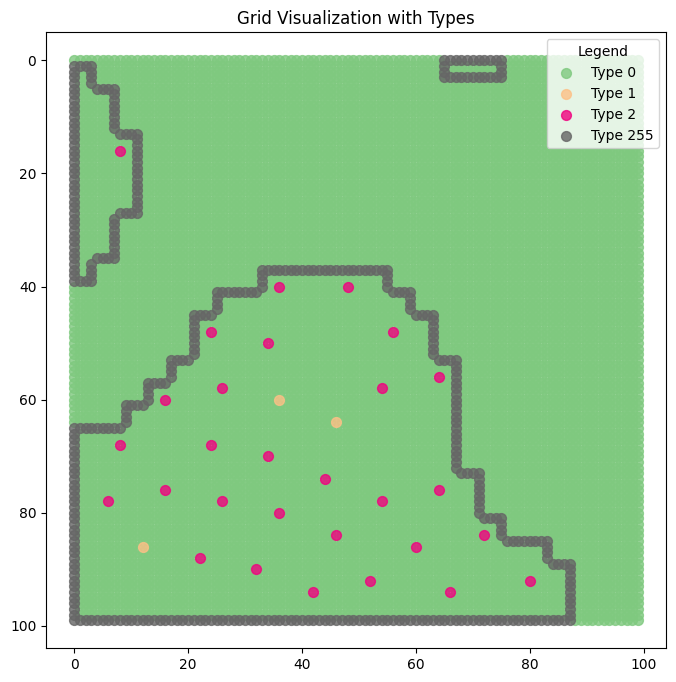

In [64]:
model = "./models/23rd.zip" # Model used for the grid Generation
grid = createGrid(model_path=model, seed=0)

visualize_grid_with_types(grid)
# 1s are trees, 2s are shrubs

In [65]:
def shade_inside_border(grid, border_value=255, fill_value=128):
    """
    Shade points inside the black borders on the grid with a specified fill color,
    leaving outside regions untouched.

    Args:
        grid (np.ndarray): The grid representing the environment.
        border_value (int): Value representing the border in the grid.
        fill_value (int): Value to fill the inside regions with.

    Returns:
        np.ndarray: Modified grid with inside regions shaded with the fill color.
    """
    # Create a mask for border areas
    border_mask = grid == border_value

    # Use binary_fill_holes to fill regions inside the border
    filled_region = binary_fill_holes(border_mask)

    # Create a copy of the grid to modify
    shaded_grid = np.copy(grid)
    
    # Apply the fill color to inside regions only
    shaded_grid[filled_region] = fill_value
    # plt.imshow(shaded_grid, cmap="gray")
    # plt.title("Grid with Inside Regions Shaded")
    # plt.show()
    
    return shaded_grid


In [66]:
def calculate_distance_to_border(grid, cutoff=1, max_area=0.4, instant_fall_off=False):
    """
    Calculate and normalize the distance of each pixel to the nearest border of the area with type 128.
    Includes a cutoff value to ignore distances below the cutoff threshold and a max_area to cap the proximity.
    Allows max_area to specify the portion of the grid covered.
    Supports an instant fall-off mode where values drop to 0 beyond the max_area range.

    Args:
        grid (np.ndarray): 2D array where 128 represents the target area.
        cutoff (float): The minimum distance value before starting to increase. Default is 1.
        max_area (float): The portion of the grid where proximity should remain non-zero. If between 0 and 1, treated as a percentage.
        instant_fall_off (bool): If True, values beyond max_area are set to 0 immediately.

    Returns:
        np.ndarray: A 2D array of the same shape as the input, containing normalized distances.
    """
    # Create a binary mask where type 128 is 1 and everything else is 0
    max_cutoff = 1 - max_area
    binary_mask = (grid == 128).astype(np.uint8)

    # Apply distance transform
    distance_to_border = cv2.distanceTransform(binary_mask, distanceType=cv2.DIST_L2, maskSize=5)

    # Apply cutoff
    distance_to_border = np.where(distance_to_border >= cutoff, distance_to_border, 0)

    # Convert max_cutoff to an absolute value if it's a percentage (0 < max_cutoff <= 1)
    max_distance = np.max(distance_to_border)
    if 0 < max_cutoff <= 1:  # If max_cutoff is a percentage
        max_cutoff = max_cutoff * max_distance

    # Set values at max_cutoff to 100 and normalize the gradient
    distance_to_border = np.clip(distance_to_border, 0, max_cutoff)  # Cap at max_cutoff
    if max_cutoff > 0:
        normalized_distance_map = (distance_to_border / max_cutoff) * 100  # Scale to range [0, 100]

    # Set values that hit max_cutoff to exactly 100
    normalized_distance_map[distance_to_border == max_cutoff] = 100

    # Handle instant fall-off: Retain yellow zones (100) and remove all other gradients
    if instant_fall_off:
        normalized_distance_map = np.where(normalized_distance_map == 100, 100, 0)

    # Flip the distance map vertically
    flipped_distance_map = np.flipud(normalized_distance_map)

    return flipped_distance_map


In [67]:
def calculate_border_proximity(grid, constant_zone=0.6, instant_fall_off=False):
    """
    Calculate a proximity map where pixels of type 128 closest to the border have the highest value.
    Type 0 remains 0. Includes a cutoff value to ignore distances below the cutoff threshold,
    a max_cutoff to cap the proximity effect, and a constant_zone where the score remains 100.
    Supports an instant fall-off mode where values less than 100 are set to 0.

    Args:
        grid (np.ndarray): 2D array where 128 represents the target area.
        cutoff (float): The minimum distance value to consider. Distances below this are set to 0.
        max_cutoff (float or percentage): The maximum distance value to cap. If between 0 and 1, treated as a percentage.
        constant_zone (float or percentage): The distance from the border where the proximity value remains 100.
                                             If between 0 and 1, treated as a percentage.
        instant_fall_off (bool): If True, values less than 100 are set to 0.

    Returns:
        np.ndarray: A 2D array where proximity to the border is higher for points closer to the border.
    """
    cutoff = 1
    max_cutoff = 1
    # Create a binary mask where type 128 is 1 and everything else is 0
    binary_mask = (grid == 128).astype(np.uint8)

    # Apply distance transform
    distance_to_border = cv2.distanceTransform(binary_mask, distanceType=cv2.DIST_L2, maskSize=5)

    # Calculate max_distance for normalization and percentage-based calculations
    max_distance = np.max(distance_to_border)

    # Convert constant_zone and max_cutoff to absolute values if they are percentages
    if 0 < constant_zone <= 1:
        constant_zone = constant_zone * max_distance
    if 0 < max_cutoff <= 1:
        max_cutoff = max_cutoff * max_distance

    # Maintain a constant value of 100 in the constant zone
    proximity_map = np.zeros_like(distance_to_border)
    proximity_map[distance_to_border <= constant_zone] = 100

    # Normalize the distances beyond the constant zone
    beyond_constant_zone = distance_to_border > constant_zone
    if max_distance > 0:
        normalized_distances = (distance_to_border[beyond_constant_zone] - constant_zone) / (max_distance - constant_zone)
        proximity_map[beyond_constant_zone] = (1 - normalized_distances) * 100

    # Apply cutoff to remove low-proximity regions
    proximity_map = np.where(distance_to_border >= cutoff, proximity_map, 0)

    # Handle instant fall-off: Set all values less than 100 to 0
    if instant_fall_off:
        proximity_map = np.where(proximity_map == 100, 100, 0)
    else:
        # Apply max_cutoff to limit the proximity range
        if max_cutoff is not None:
            proximity_map = np.where(distance_to_border <= max_cutoff, proximity_map, 0)

    # Flip the proximity map vertically
    flipped_proximity_map = np.flipud(proximity_map)

    return flipped_proximity_map

Loaded model from ./models/23rd.zip
Episode finished after 425 steps


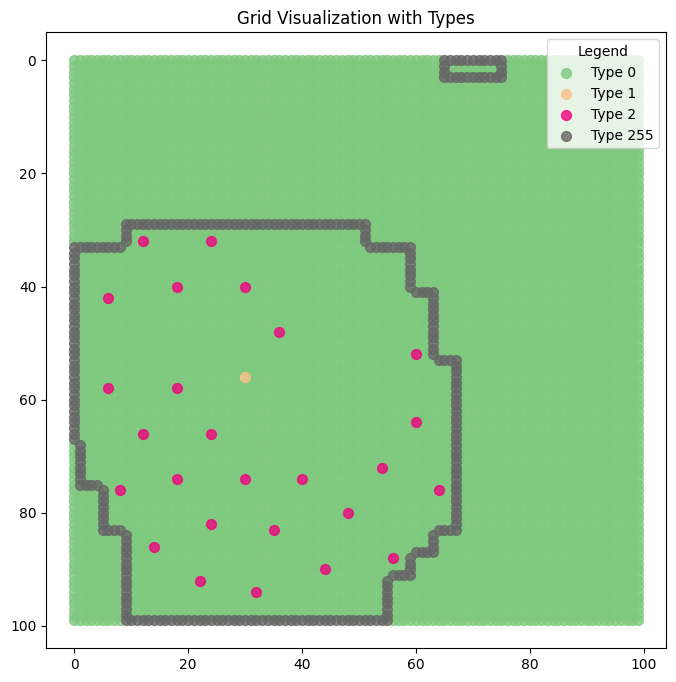

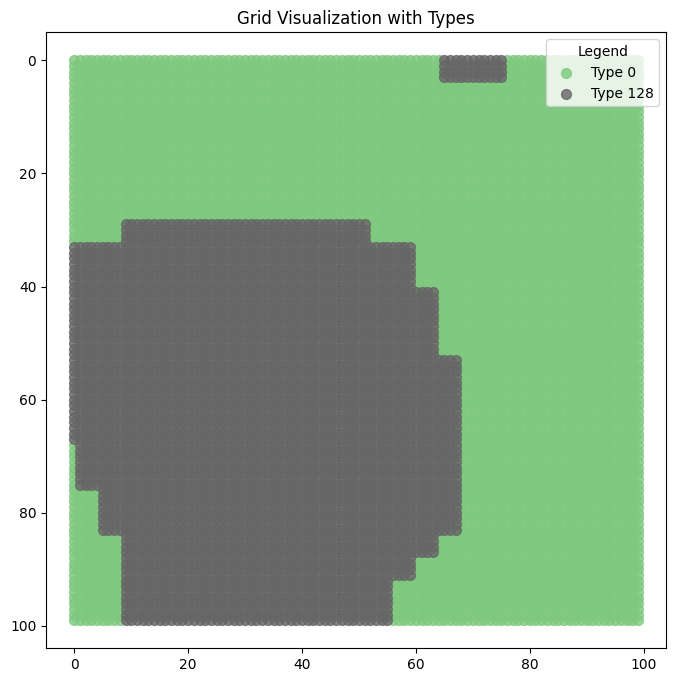

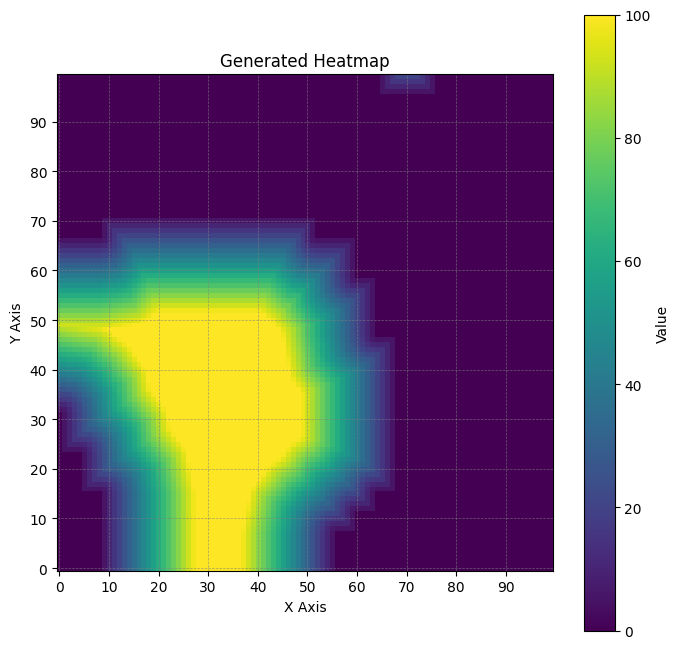

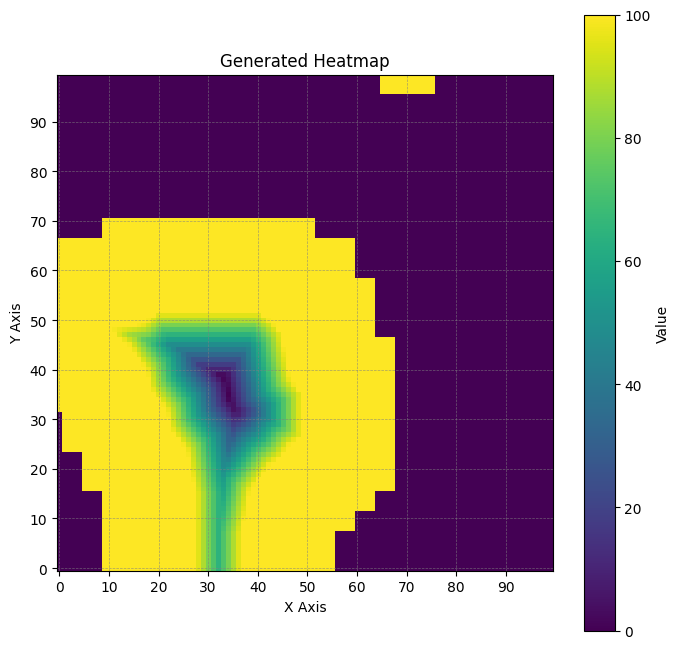

In [68]:
input = createGrid(model_path=model, seed=4)
visualize_grid_with_types(input)
grid = shade_inside_border(input)
# Example usage
normalized_distance_map = calculate_distance_to_border(grid)  # Toggle invert as needed

visualize_grid_with_types(grid)
visualize_heatmap(normalized_distance_map)

other_distance_map = calculate_border_proximity(grid)
visualize_heatmap(other_distance_map)


Might play around with the idea of direct cutoff at the end of this

<h1> Old Code </h1>

In [ ]:
def label_heatmap_based_on_trees(grid, tree_positions, invert=False, distance_threshold=20):
    """
    Creates a new grid where points with a value of 128 are labeled with 100 or 0 
    based on their proximity to trees. Points within or outside the specified distance 
    threshold are labeled, depending on `invert`.

    Args:
        grid (np.ndarray): The input grid (heatmap values or similar structure).
        tree_positions (list of tuple): List of (y, x) coordinates of tree locations.
        invert (bool): If True, label points outside the distance threshold instead of within it.
        distance_threshold (float): The distance threshold for labeling.

    Returns:
        np.ndarray: A new grid where desired squares are labeled as 100, others as 0.
    """
    # Initialize the new grid with zeros
    labeled_grid = np.zeros_like(grid, dtype=np.float32)
    
    # Identify positions with a value of 128 in the grid
    target_positions = np.argwhere(grid == 128)
    
    # If there are tree positions and target positions, calculate distances
    if len(tree_positions) > 0 and len(target_positions) > 0:
        tree_positions = np.array(tree_positions)
        
        # Calculate distances from target positions to the tree positions
        distances = cdist(target_positions, tree_positions)
        min_distances = np.min(distances, axis=1)
        
        # Determine indices based on the distance threshold
        if invert:
            # Label points outside the distance threshold
            valid_indices = np.where(min_distances > distance_threshold)[0]
        else:
            # Label points within the distance threshold
            valid_indices = np.where(min_distances <= distance_threshold)[0]
        
        # Mark valid target points in the labeled grid
        for index in valid_indices:
            y, x = target_positions[index]
            labeled_grid[y, x] = 100  # Assign the value 100 for valid points

        labeled_grid = np.flipud(labeled_grid)

    return labeled_grid

[(56, 30)]


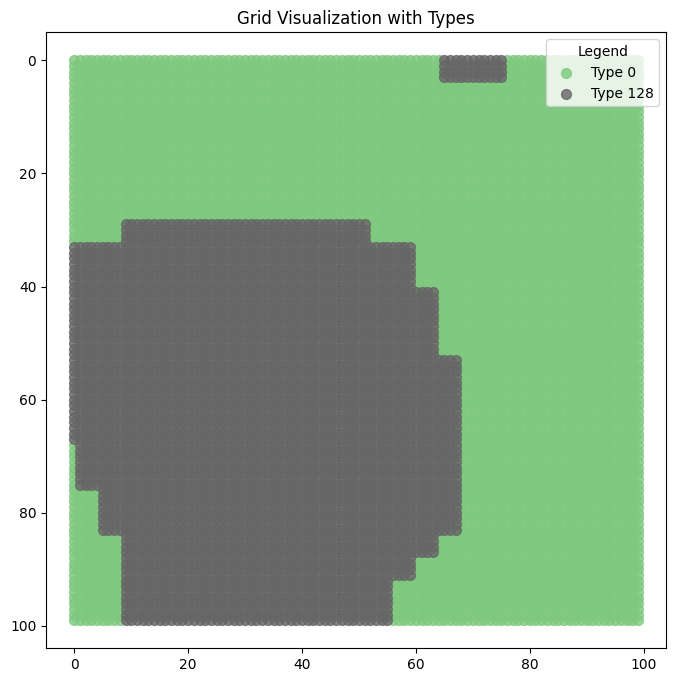

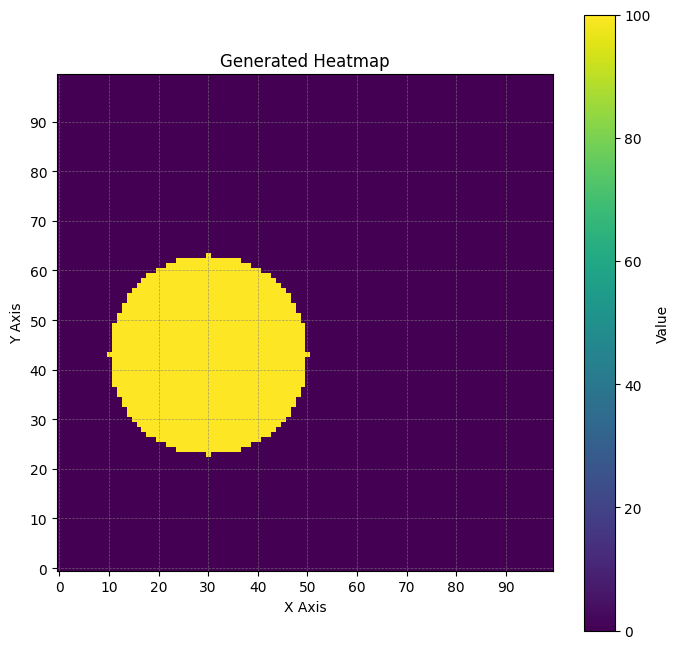

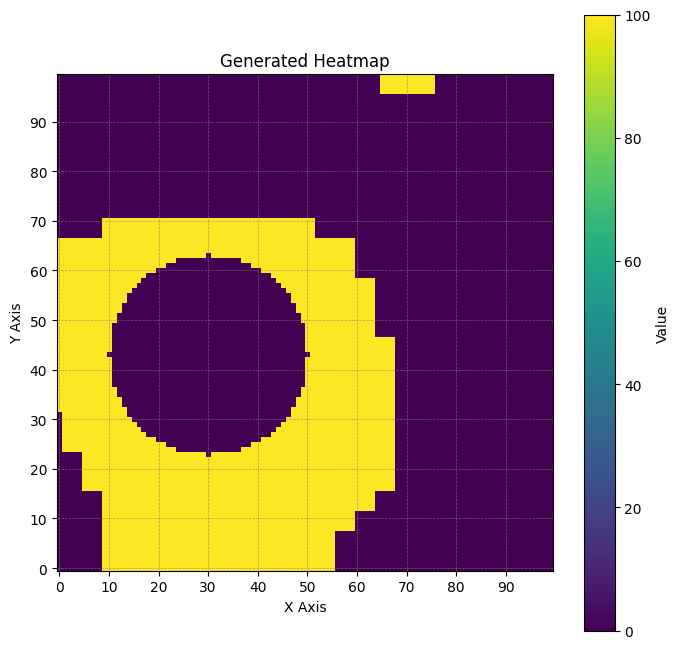

In [85]:
trees, shrubs = extract_tree_shrub_placements(input)
print(trees)
new_grid = label_heatmap_based_on_trees(grid,trees)
visualize_grid_with_types(grid)
visualize_heatmap(new_grid)
new_grid = label_heatmap_based_on_trees(grid,trees,invert=True)
visualize_heatmap(new_grid)

<h1> New Code </h1>

In [69]:
# example dictionary
# only going to fake the plant_type, shade, fauna_attracting, hazardous, canopy_radius

## Theoretically, I should be accounting for water preference also
dict_of_plant_from_wx_part = {
    "selected_plants": [
        {
            "Plant Type": "Herbaceous Plant, Shrub",
            "Light Preference": "Full Shade, Semi Shade",
            "Attracted Animals": "Bee-Attracting",
            "Hazard": "-",
            "Canopy Radius": "None",
            "Species Name": "Bird's Nest Fern"
        },
        {
            "Plant Type": "Herbaceous Plant, Shrub",
            "Light Preference": "Full Shade, Semi Shade",
            "Attracted Animals": "-",
            "Hazard": "Toxic Upon Ingestion",
            "Canopy Radius": "None",
            "Species Name": "Horse Cassia"
        },
        {
            "Plant Type": "Herbaceous Plant, Tree",
            "Light Preference": "Full Shade, Semi Shade",
            "Attracted Animals": "-",
            "Hazard": "Toxic Upon Ingestion",
            "Canopy Radius": "19",
            "Species Name": "Seashore Ardisia"
        },
        {
            "Plant Type": "Palm",
            "Light Preference": "Full Shade, Semi Shade",
            "Attracted Animals": "-",
            "Hazard": "-",
            "Canopy Radius": "10",
            "Species Name": "Fishtail Palm"
        }
    ],
    "theme": "naturalistic"
}


Randomly choose a tree species to be asigned to coordinate

In [70]:
def allocate_trees_to_coordinates(tree_positions, plant_data):
    """
    Allocates a tree species and its radius to each coordinate from the given plant dictionary.

    Args:
        coordinates (list of tuple): List of (y, x) grid coordinates.
        plant_data (dict): Dictionary containing plant information.

    Returns:
        dict: A dictionary mapping each coordinate to a tree species and its radius.
    """
    # Filter out only plants that are classified as trees
    tree_species = [
        plant for plant in plant_data["selected_plants"]
        if "Tree" in plant["Plant Type"]
    ]
    
    # Check if there are any tree species
    if not tree_species:
        raise ValueError("No tree species available in the plant data.")

    # Initialize the output dictionary
    allocated_trees = {}

    # Assign each coordinate a tree species and radius
    for pos in tree_positions:
        # Randomly select a tree species
        selected_tree = random.choice(tree_species)
        name = selected_tree["Species Name"]
        radius = selected_tree.get("Canopy Radius", "None")
        
        # Ensure radius is a float if possible
        radius = float(radius) if radius != "None" else 0
        
        # Allocate the tree to the coordinate
        allocated_trees[pos] = [name, radius]

    return allocated_trees

In [48]:
def label_heatmap_based_on_trees_v2(grid, tree_data, invert=False):
    """
    Creates a new grid where points with a value of 128 are labeled with 100 or 0 
    based on their proximity to trees. Each tree has a specific radius for labeling.
    Points within or outside the radius are labeled, depending on `invert`.

    Args:
        grid (np.ndarray): The input grid (heatmap values or similar structure).
        tree_data (dict): Dictionary with (y, x) coordinates as keys and radius as values.
        invert (bool): If True, label points outside the radius instead of within it.

    Returns:
        np.ndarray: A new grid where desired squares are labeled as 100, others as 0.
    """
    # Initialize the new grid with zeros
    labeled_grid = np.zeros_like(grid, dtype=np.float32)
    
    # Identify positions with a value of 128 in the grid
    target_positions = np.argwhere(grid == 128)
    
    # If there are tree positions and target positions, calculate distances
    if len(tree_data) > 0 and len(target_positions) > 0:
        # Extract tree positions and radii
        tree_positions = np.array(list(tree_data.keys()))
        tree_radii = np.array(list(tree_data.values()))
        
        # Calculate distances from target positions to the tree positions
        distances = cdist(target_positions, tree_positions)
        
        # For each tree, label points based on its radius
        for i, radius in enumerate(tree_radii):
            if invert:
                # Label points outside the current tree's radius
                valid_indices = np.where(distances[:, i] > radius)[0]
            else:
                # Label points within the current tree's radius
                valid_indices = np.where(distances[:, i] <= radius)[0]
            
            # Mark valid target points in the labeled grid
            for index in valid_indices:
                y, x = target_positions[index]
                labeled_grid[y, x] = 100  # Assign the value 100 for valid points

        labeled_grid = np.flipud(labeled_grid)

    return labeled_grid

{(56, 30): ['Seashore Ardisia', 19.0]}


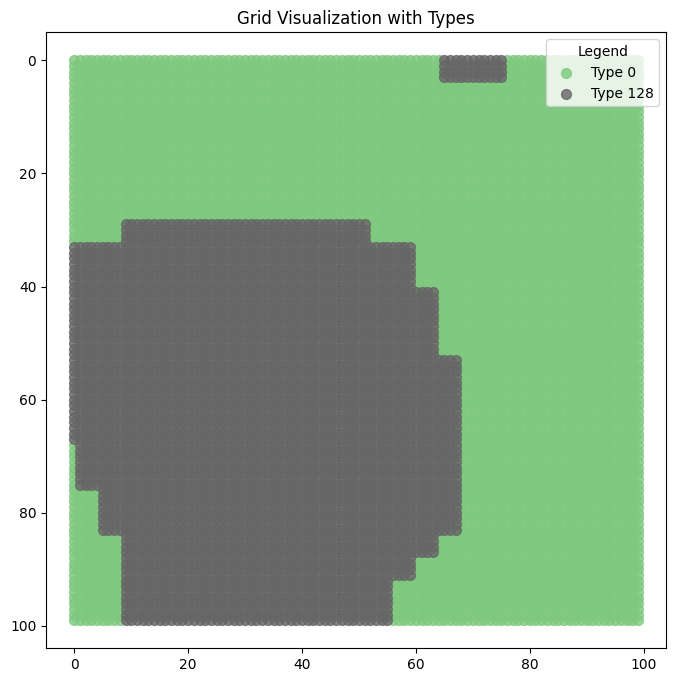

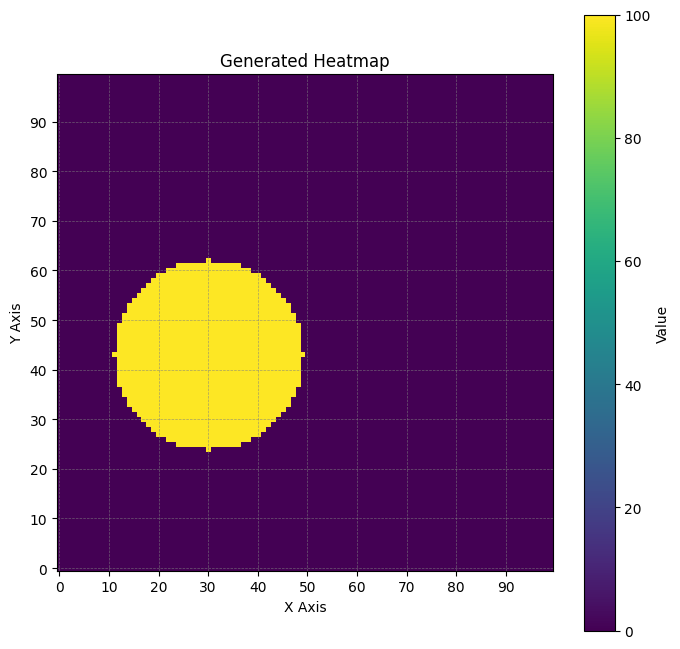

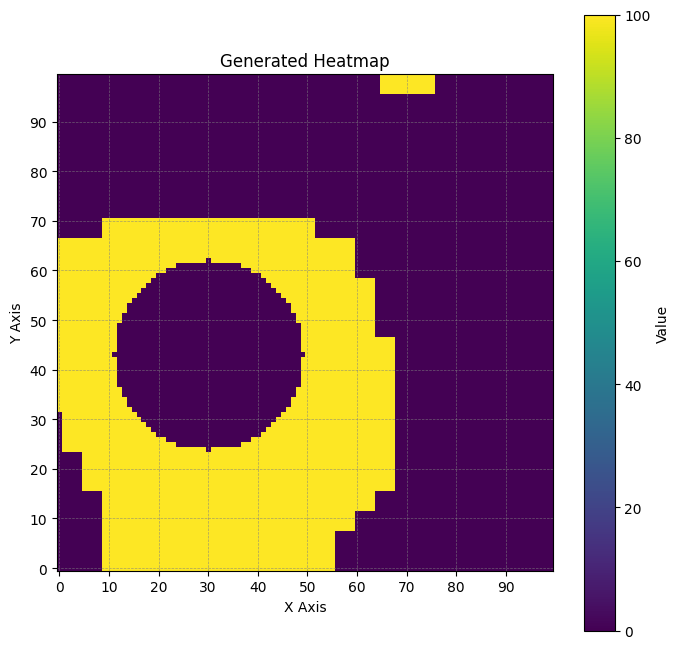

In [84]:
trees, shrubs = extract_tree_shrub_placements(input)  # Ensure trees is now a dictionary {(y, x): radius}
new_trees = allocate_trees_to_coordinates(trees, dict_of_plant_from_wx_part)  # Returns {(y, x): ["name", radius]}
print(new_trees)
# Extract just the radii for the heatmap function
tree_radii = {pos: data[1] for pos, data in new_trees.items()}  # Process new_trees to get {(y, x): radius}

# Generate the heatmap based on tree radii
new_grid = label_heatmap_based_on_trees_v2(grid, tree_radii)

# Visualize the grid and heatmap
visualize_grid_with_types(grid)
visualize_heatmap(new_grid)

# Generate the inverted heatmap
new_grid = label_heatmap_based_on_trees_v2(grid, tree_radii, invert=True)
visualize_heatmap(new_grid)


In [78]:
seeds = [3,4,5,6]

In [80]:
def combine_heatmaps(heatmaps):
    """
    Combine multiple heatmaps into a single heatmap by summing them element-wise.

    Args:
        heatmaps (list of np.ndarray): List of 2D heatmaps to combine.

    Returns:
        np.ndarray: Combined heatmap with the same shape as the input heatmaps.
    """
    if not heatmaps:
        raise ValueError("The list of heatmaps is empty.")
    
    # Ensure all heatmaps have the same shape
    shape = heatmaps[0].shape
    for idx, h in enumerate(heatmaps):
        if h.shape != shape:
            print(f"Heatmap at index {idx} has shape {h.shape}, expected {shape}")
            raise ValueError("All heatmaps must have the same shape.")
    
    # Sum the heatmaps element-wise
    combined = sum(heatmaps)
    
    return combined


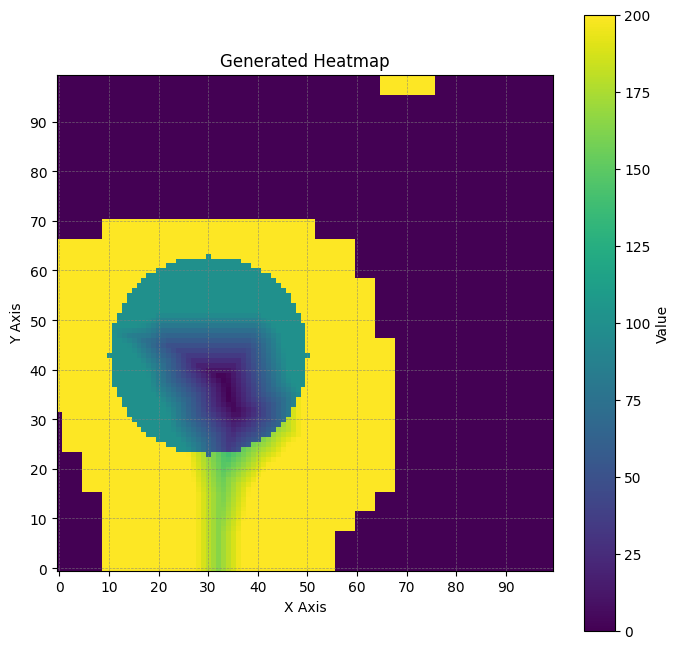

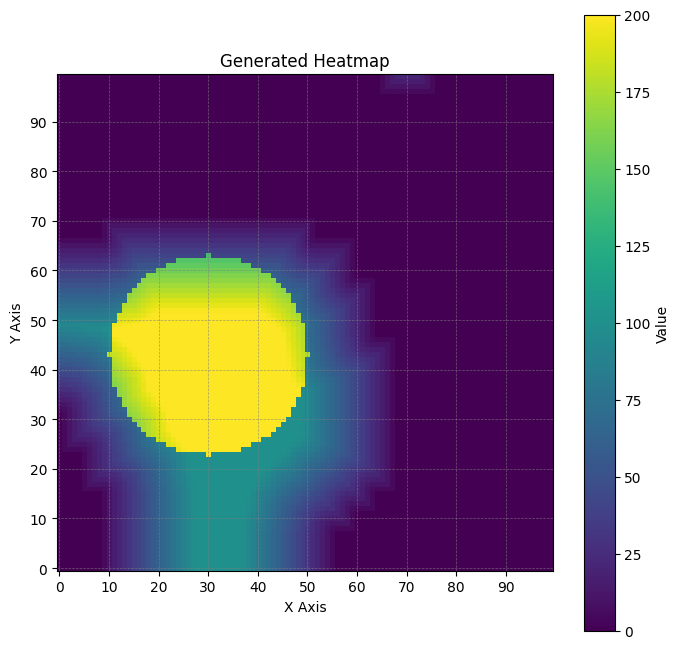

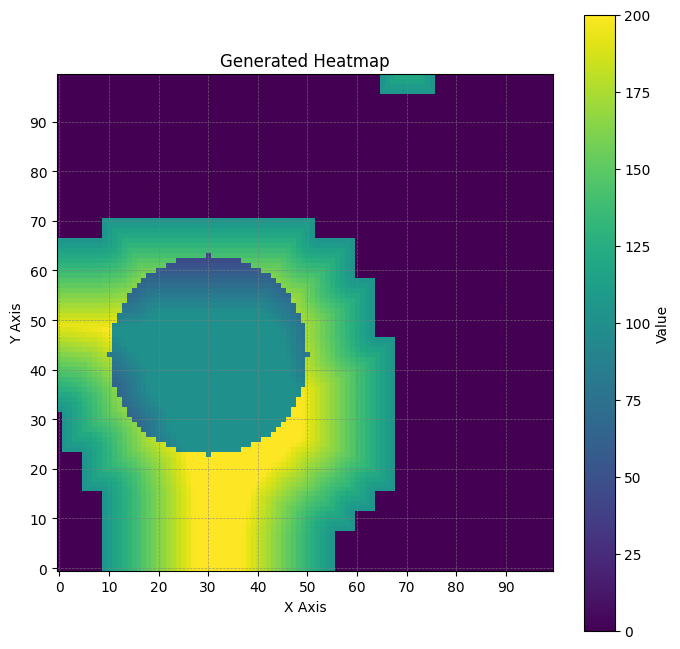

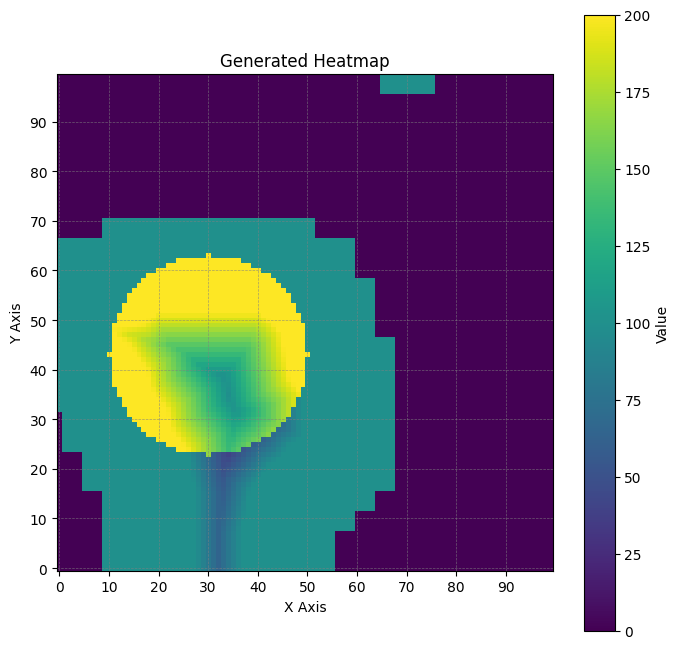

In [83]:
def create_heatmap_for_type(seed_value, grid):
    plantable_grid = shade_inside_border(grid)
    trees, shrubs = extract_tree_shrub_placements(grid)
    # Create the grids to be combined
    shade_grid = None
    # If the thing is a multiple of 2 then it is shade loving
    if seed_value%2 == 0:
        shade_grid = label_heatmap_based_on_trees(plantable_grid,trees)
    else:
        shade_grid = label_heatmap_based_on_trees(plantable_grid, trees, invert=True)
    border_grid = None
    # If the seed_value is a modulus of 3 then it is something that likes the border
    if seed_value%3 ==0:
        border_grid = calculate_border_proximity(plantable_grid)
    else:
        border_grid = calculate_distance_to_border(plantable_grid)
    
    # visualize_heatmap(shade_grid)
    # visualize_heatmap(border_grid)
    influences = [shade_grid,border_grid]
    influence = combine_heatmaps(influences)
    visualize_heatmap(influence)
    return influence


seed_heatmaps = {
    3: create_heatmap_for_type(3, input),
    4: create_heatmap_for_type(4, input),
    5: create_heatmap_for_type(5, input),
    6: create_heatmap_for_type(6, input)
} 

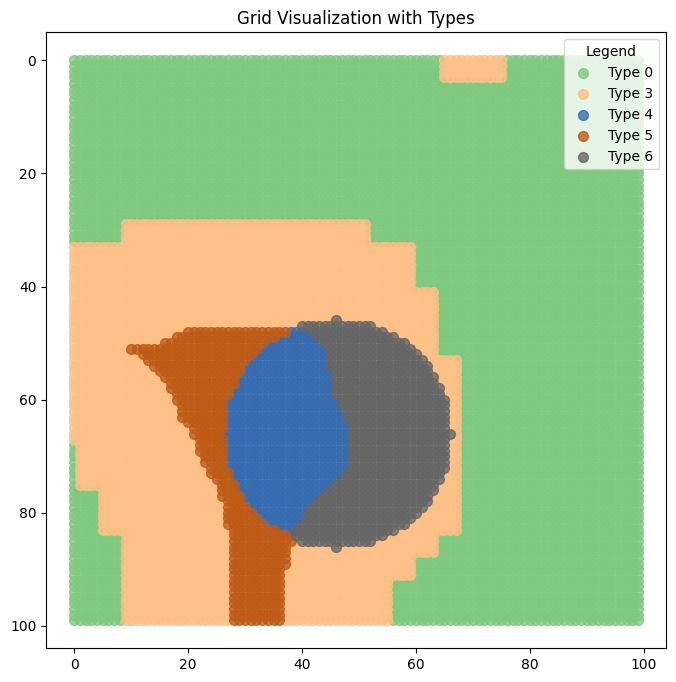

In [17]:
def apply_influence_grids_with_border(influence_grids, grid, threshold=1):
    """
    Apply influence grids to assign plant types based on influences while respecting the border constraints.
    Correct the vertical flip issue by flipping the grid as needed.

    Args:
        influence_grids (dict): A dictionary of influence grids for each plant type.
        grid (np.ndarray): Original grid to determine workable spots.
        threshold (float): The maximum absolute difference between influences to trigger random selection.

    Returns:
        np.ndarray: A grid with plant types assigned based on influence grids, keeping non-workable spots untouched.
    """
    # Identify workable spots using shade_inside_border
    workable_grid = shade_inside_border(grid)
    
    # Flip grids vertically to address the issue
    flipped_influence_grids = {
        plant_type: np.flipud(influence_grids[plant_type])
        for plant_type in influence_grids
    }
    
    grid_shape = workable_grid.shape

    # Initialize the assigned grid with zeros
    assigned_grid = np.zeros(grid_shape, dtype=int)

    # Iterate through each cell in the grid
    for i in range(grid_shape[0]):
        for j in range(grid_shape[1]):
            if workable_grid[i, j] == 128:  # Only consider workable spots
                # Gather influences for all plant types at this position
                influences = [
                    (flipped_influence_grids[plant_type][i, j], plant_type)
                    for plant_type in flipped_influence_grids
                ]

                # Sort influence values with their corresponding types
                influences.sort(reverse=True, key=lambda x: x[0])  # Sort by influence value

                # Decide based on the absolute threshold
                if len(influences) > 1 and abs(influences[0][0] - influences[1][0]) <= threshold:
                    # Randomly select between the top two types
                    assigned_type = random.choice([influences[0][1], influences[1][1]])
                else:
                    # Select the type with the highest influence
                    assigned_type = influences[0][1]

                # Assign the type to the corresponding cell
                assigned_grid[i, j] = assigned_type
            else:
                # Retain the original value for non-workable spots (e.g., 0)
                assigned_grid[i, j] = grid[i, j]

    return assigned_grid

newer_grid = apply_influence_grids_with_border(seed_heatmaps, input)
visualize_grid_with_types(newer_grid)

Add a little bit of noise in using the previous functions

In [18]:
def choose_starter_slots(grid, shrub_positions, starter_types, percentage_of_starters=0.8):
    """
    Selects a percentage of shrub positions to be assigned as starter slots and updates the grid with new types
    based on the provided list of starter types.

    Args:
        grid (np.ndarray): The current grid representing the environment.
        shrub_positions (list): List of tuples representing the positions of shrubs on the grid.
        starter_types (list): List of integers representing the types to assign.
        percentage_of_starters (float): Percentage of shrub positions to use as starter slots. Default is 0.8 (80%).

    Returns:
        tuple: Updated grid with starter slots assigned, and a dictionary of seed locations by type.
    """
    working_grid = copy.deepcopy(grid)
    shrub_slots = copy.deepcopy(shrub_positions)
    seed_locations = {t: [] for t in starter_types}

    # Determine the number of starters based on the percentage
    number_of_starters = int(len(shrub_slots) * percentage_of_starters)
    number_of_starters = max(1, number_of_starters)  # Ensure at least one starter is selected

    # Use the provided list of starter types in sequence
    types_sequence = [starter_types[i % len(starter_types)] for i in range(number_of_starters)]

    for i, assigned_type in enumerate(types_sequence):
        if not shrub_slots:  # If no more shrub positions are left, break the loop
            break
        selected_position = shrub_slots.pop(0)  # Select the next shrub position in order
        working_grid[selected_position[0], selected_position[1]] = assigned_type
        seed_locations[assigned_type].append(selected_position)

    return working_grid, seed_locations

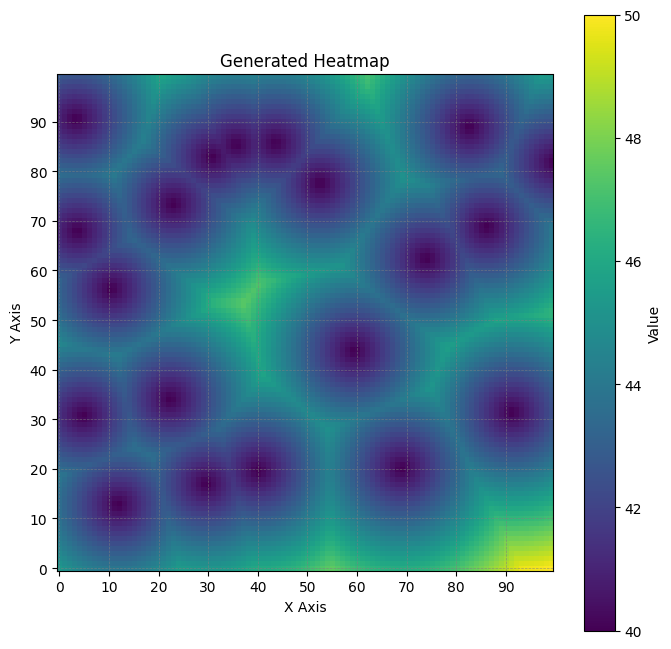

In [19]:
def generate_worley_heatmap(grid_size=(100, 100), distribution_seed=None, value_range=(40, 50), feature_points=20, invert=False):
    """
    Generate a random heatmap using Worley noise.

    Args:
        grid_size (tuple): The size of the heatmap (width, height).
        distribution_seed (int or None): Seed for reproducibility.
        value_range (tuple): The range of values for the heatmap (min, max).
        feature_points (int): Number of feature points in the grid.
        invert (bool): Whether to invert the values so that centers of the points are high-value areas.

    Returns:
        np.ndarray: A 2D array representing Worley noise.
    """
    width, height = grid_size

    # Set random seed for reproducibility
    if distribution_seed is not None:
        random.seed(distribution_seed)

    # Generate random feature points
    feature_points = [(random.uniform(0, width), random.uniform(0, height)) for _ in range(feature_points)]

    def closest_distance(x, y):
        # Compute the closest distance to a feature point
        return min(np.sqrt((x - fx) ** 2 + (y - fy) ** 2) for fx, fy in feature_points)

    # Compute Worley noise for the grid
    noise = np.array([[closest_distance(x, y) for x in range(width)] for y in range(height)])

    # Normalize the noise to 0-1
    noise = (noise - np.min(noise)) / (np.max(noise) - np.min(noise))

    # Invert the noise if required
    if invert:
        noise = 1 - noise

    # Scale the noise to the desired value range
    min_val, max_val = value_range
    noise = noise * (max_val - min_val) + min_val

    return noise

heatmap = generate_worley_heatmap()
visualize_heatmap(heatmap)

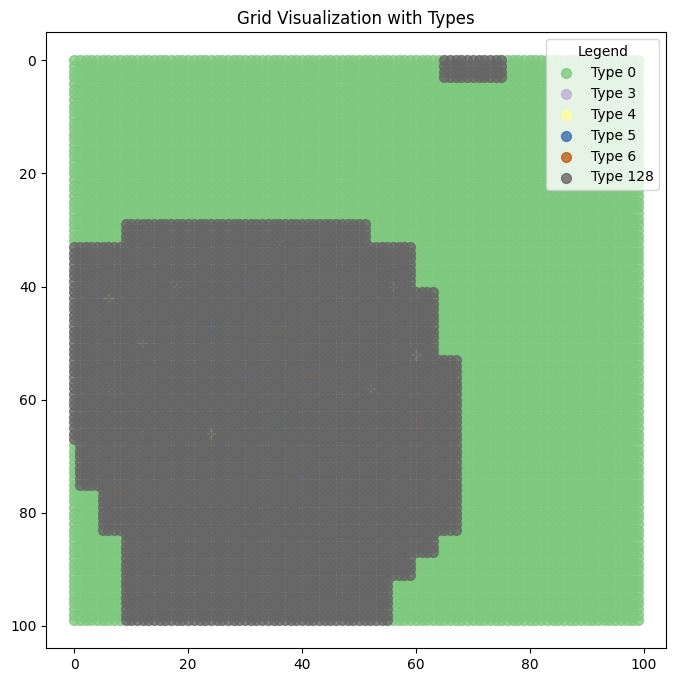

{3: [(32, 36), (40, 56), (50, 12), (58, 6), (66, 12)], 4: [(40, 18), (42, 6), (52, 60), (58, 52), (66, 24)], 5: [(40, 30), (48, 24), (56, 30), (64, 36), (74, 40)], 6: [(40, 42), (48, 36), (56, 42), (64, 60), (76, 8)]}


In [20]:
trees, shrubs = extract_tree_shrub_placements(input)
working_grid, seed_locations = choose_starter_slots(grid, shrubs, [3,4,5,6])

visualize_grid_with_types(working_grid)
print(seed_locations)

In [21]:
def radiate_influence(grid, noise_map, seed_locations, decay_rate=0.1):
    """
    Radiates influence from each seed location based on its strength on the noise map, taking the maximum influence.

    Args:
        grid (np.ndarray): The input grid where influence will be applied.
        noise_map (np.ndarray): A grid representing the noise values.
        seed_locations (list of tuple): List of (y, x) seed coordinates.
        decay_rate (float): The rate at which influence decreases with distance.

    Returns:
        np.ndarray: A grid with the maximum influence from all seeds.
    """
    # Initialize the influence grid with zeros
    influence_grid = np.zeros_like(grid, dtype=np.float32)

    # Get grid dimensions
    height, width = grid.shape

    # Iterate over each seed
    for y, x in seed_locations:
        # Get the seed's strength from the noise map
        if 0 <= y < height and 0 <= x < width:
            seed_strength = noise_map[y, x]

            # Iterate over the grid to calculate influence
            for i in range(height):
                for j in range(width):
                    # Calculate the distance from the seed
                    distance = np.sqrt((i - y) ** 2 + (j - x) ** 2)

                    # Calculate the influence based on the distance
                    influence = seed_strength * np.exp(-decay_rate * distance)

                    # Assign the maximum influence to the grid
                    influence_grid[i, j] = max(influence_grid[i, j], influence)

    influence_grid = np.flipud(influence_grid)

    return influence_grid


noise_grids =  {
    3: radiate_influence(input, heatmap, seed_locations[3]),
    4: radiate_influence(input, heatmap, seed_locations[4]),
    5: radiate_influence(input, heatmap, seed_locations[5]),
    6: radiate_influence(input, heatmap, seed_locations[6]),              
}

In [22]:
def create_heatmap_for_type(seed_value, grid, noise_grid, fall_off=False):
    plantable_grid = shade_inside_border(grid)
    trees, shrubs = extract_tree_shrub_placements(grid)
    # Create the grids to be combined
    shade_grid = None
    # If the thing is a multiple of 2 then it is shade loving
    if seed_value%2 == 0:
        shade_grid = label_heatmap_based_on_trees(plantable_grid,trees)
    else:
        shade_grid = label_heatmap_based_on_trees(plantable_grid, trees, invert=True)
    border_grid = None
    # If the seed_value is a modulus of 3 then it is something that likes the border
    if seed_value%3 ==0:
        border_grid = calculate_border_proximity(plantable_grid, instant_fall_off=fall_off)
    else:
        border_grid = calculate_distance_to_border(plantable_grid)
    
    # visualize_heatmap(shade_grid)
    # visualize_heatmap(border_grid)
    influences = [shade_grid,border_grid, noise_grid]
    influence = combine_heatmaps(influences)
    # visualize_heatmap(influence)
    return influence


seed_heatmaps = {
    3: create_heatmap_for_type(3, input, noise_grids[3]),
    4: create_heatmap_for_type(4, input, noise_grids[4]),
    5: create_heatmap_for_type(5, input, noise_grids[5]),
    6: create_heatmap_for_type(6, input, noise_grids[6])
} 

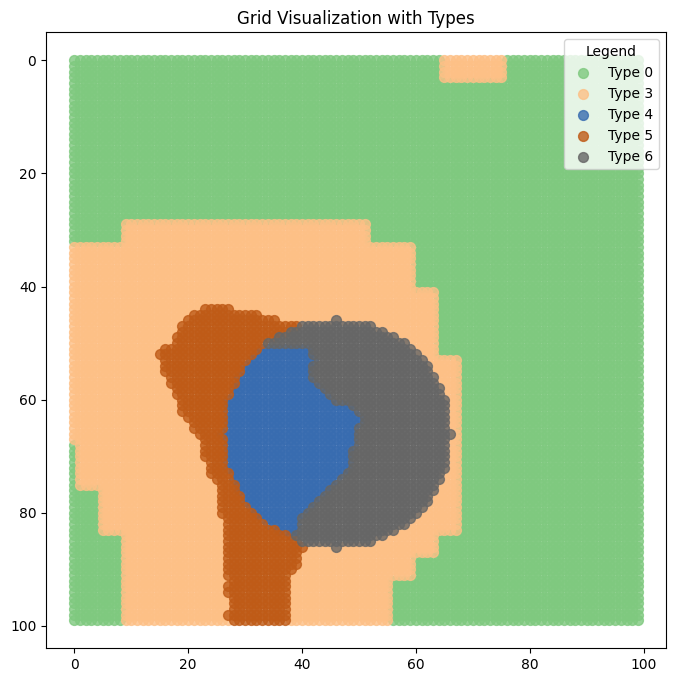

In [23]:
newer_grid = apply_influence_grids_with_border(seed_heatmaps, input)
visualize_grid_with_types(newer_grid)

In [24]:
def combined_noisemap(grid, noise_map, seed_dict):
    seed = {}
    for i in seed_dict:
        seed[i] = radiate_influence(grid, noise_map, seed_dict[i])
    return seed

In [25]:
def create_heatmaps(seed_list, grid, noise_grids, fall_off= False):
    seed_heatmaps = {}
    for i in seed_list:
        seed_heatmaps[i] = create_heatmap_for_type(i,grid, noise_grids[i], fall_off=fall_off)
    return seed_heatmaps

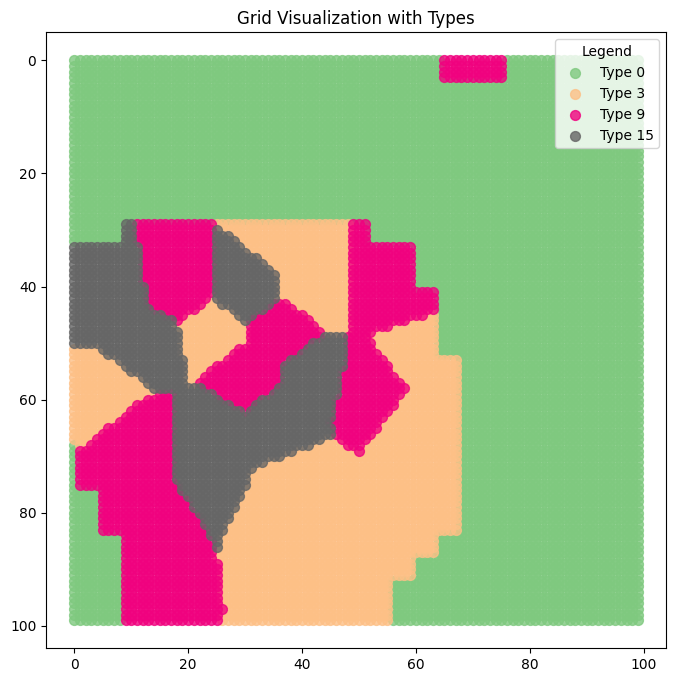

[(32, 36), (40, 18), (40, 30), (40, 42), (40, 56), (42, 6), (48, 24), (48, 36), (50, 12), (52, 60), (56, 30), (56, 42), (58, 6), (58, 52), (64, 36), (64, 60), (66, 12), (66, 24), (74, 40), (76, 8), (80, 48), (86, 14), (88, 56), (90, 44), (92, 22), (94, 32)]


In [26]:
def combined(input_grid, seed_list, threshold = 1, fall_off = False, visualise= False):
    trees, shrubs = extract_tree_shrub_placements(input)
    working_grid, seed_locations = choose_starter_slots(input,shrubs, (seed_list))
    noise_map = generate_worley_heatmap()
    noise_grids = combined_noisemap(input_grid, noise_map,seed_locations)
    heatmaps = create_heatmaps(seed_list,input_grid,noise_grids, fall_off)
    if visualise:
        for i in heatmaps:
            visualize_heatmap(heatmaps[i])
    output_grid = apply_influence_grids_with_border(heatmaps, input, threshold=threshold)

    visualize_grid_with_types(output_grid)
    return output_grid, shrubs
    

output_grid, seed_locations = combined(input, [3,9, 15], threshold= 0.1, fall_off=False, visualise=False)
# output_grid = combined(input, [3,9,15])
# output_grid = combined(input, [3,5,9,15])

print(seed_locations)

### Adding the filtering to remove stray pimples as well as adding the sort_seeds

In [27]:
def fill_small_regions(grid, min_size=50, required_points=[]):
    """
    Replace small patches (connected components) in a grid with surrounding tile values.
    Additionally, replace regions that do not contain at least one required point.

    Args:
        grid (np.ndarray): The input 2D grid with integer values (e.g., 3 and above for regions).
        min_size (int): The minimum size for a region to remain unchanged.
        required_points (list of tuple): List of (y, x) coordinates. Regions missing these points will be replaced.

    Returns:
        np.ndarray: A grid with small regions filled with surrounding tile values.
    """
    # Create a copy of the grid to modify
    cleaned_grid = np.copy(grid)
    
    # Identify unique region values (starting from 3)
    unique_values = np.unique(grid[grid >= 3])  # Ignore values less than 3
    
    # Iterate over unique values in the grid
    for value in unique_values:
        # Create a mask for the current region
        mask = (grid == value)
        
        # Label connected components within the mask
        labeled_mask, num_features = label(mask)
        
        # Iterate over connected components
        for region_label in range(1, num_features + 1):
            # Extract the region
            region_mask = (labeled_mask == region_label)
            region_size = np.sum(region_mask)
            region_coords = np.argwhere(region_mask)

            # Check if the region contains at least one required point
            contains_required_point = any(tuple(coord) in required_points for coord in region_coords)

            # If the region size is smaller than the threshold or does not contain a required point
            if region_size < min_size or not contains_required_point:
                # Collect surrounding values for all pixels in the region
                surrounding_values = []
                for y, x in region_coords:
                    # Check all 8 neighbors
                    for dy, dx in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
                        ny, nx = y + dy, x + dx
                        if 0 <= ny < grid.shape[0] and 0 <= nx < grid.shape[1]:  # Check bounds
                            neighbor_value = cleaned_grid[ny, nx]
                            surrounding_values.append(neighbor_value)
                
                # Determine the most frequent surrounding value
                values = {}
                for x in surrounding_values:
                    if x not in values:
                        values[x] = 1
                    else:
                        values[x] += 1

                replacement_value = None
                while replacement_value is None:
                    replacement_value = max(values, key=values.get)
                    if replacement_value == 0:
                        replacement_value = None
                        values.pop(max(values, key=values.get), None)

                # Replace the small region or region without required points
                cleaned_grid[region_mask] = replacement_value

    return cleaned_grid

In [28]:
def sort_seeds_v2(grid, seeds):
    """
    Sorts the seeds based on their corresponding values on a grid.

    Args:
        grid (np.ndarray): A 2D numpy array representing the grid.
        seeds (list of tuples): A list of (x, y) coordinate tuples.

    Returns:
        dict: A dictionary where keys are grid values and values are lists of coordinates.
    """
    sorted_seeds = {}

    for y, x in seeds:
        # Get the value at the grid position
        value = grid[y, x]  # Note: grid indexing is row-major (y, x)

        # Add the coordinate to the appropriate list in the dictionary
        if value not in sorted_seeds:
            sorted_seeds[value] = []
        sorted_seeds[value].append((y, x))

    sorted_seeds = dict(sorted(sorted_seeds.items()))
    return sorted_seeds

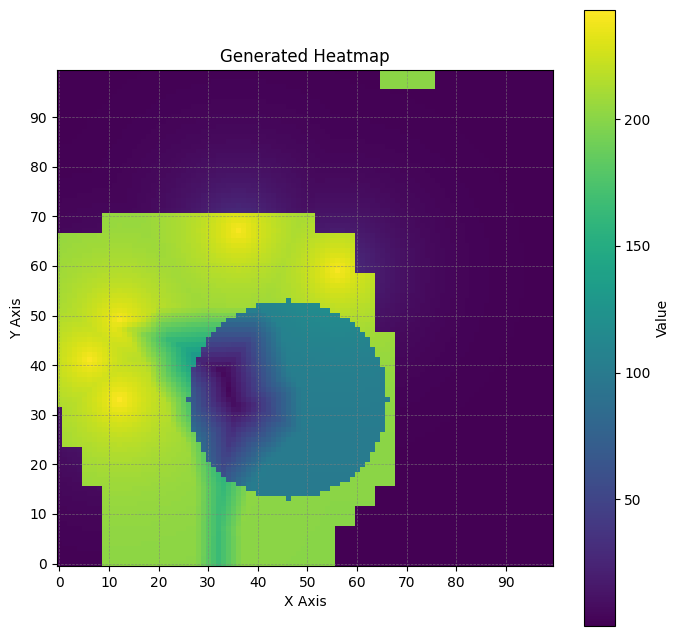

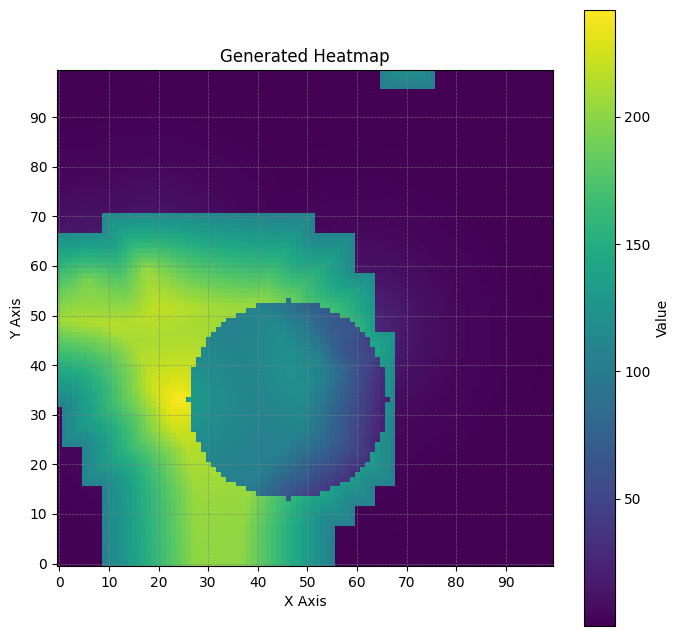

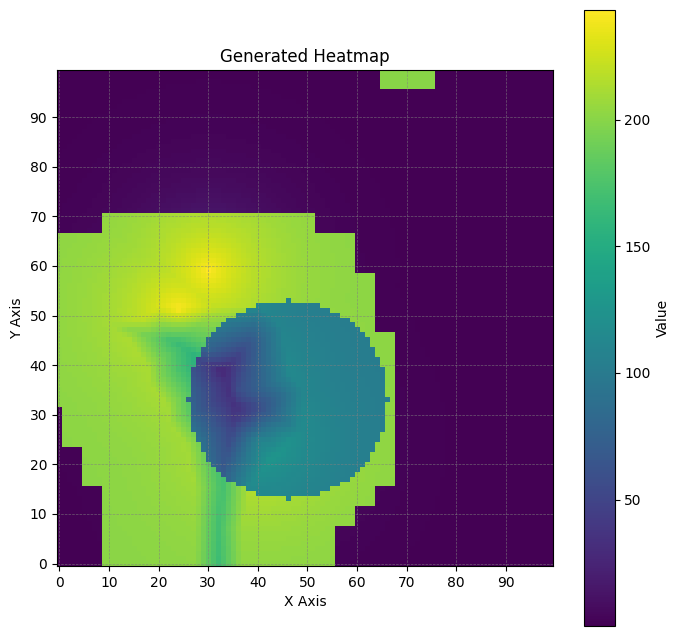

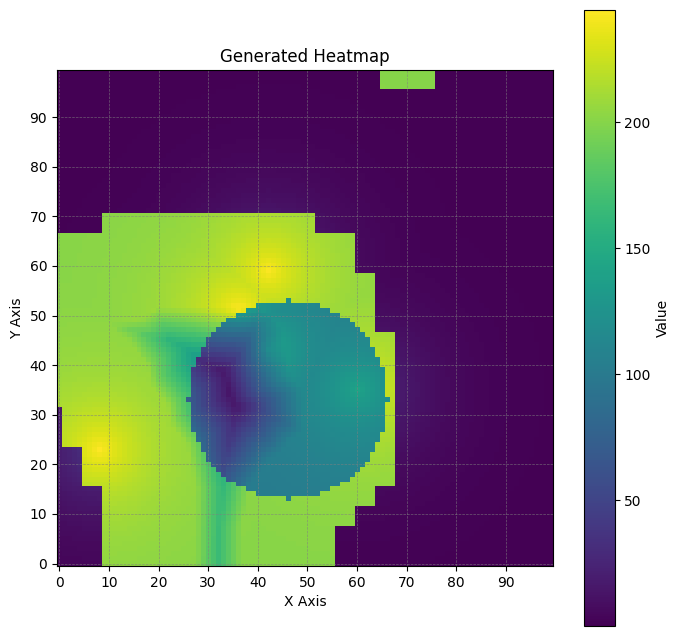

{3: [(32, 36), (40, 56), (42, 6), (50, 12), (58, 6), (66, 12)], 5: [(56, 30), (64, 36), (66, 24), (94, 32)], 9: [(40, 18), (40, 30), (48, 24), (74, 40), (80, 48), (88, 56), (90, 44)], 15: [(40, 42), (48, 36), (52, 60), (56, 42), (58, 52), (64, 60), (76, 8), (86, 14), (92, 22)]}


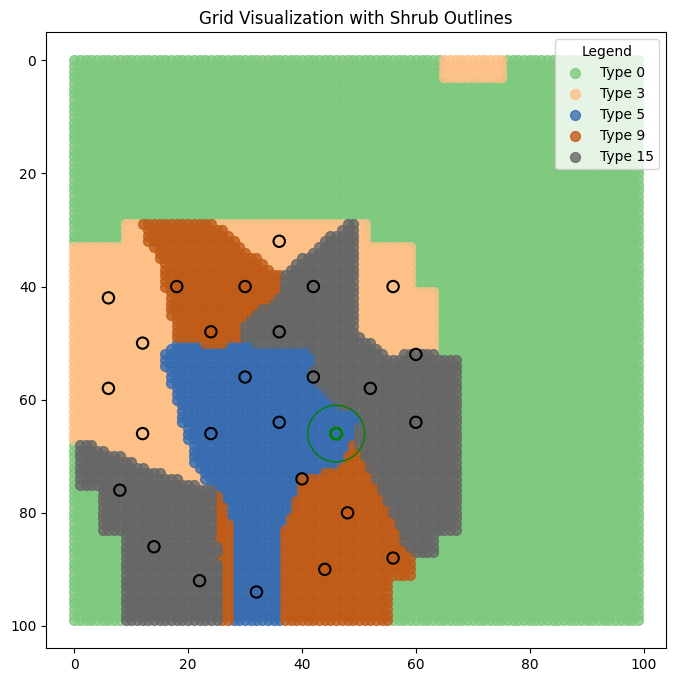

In [29]:
def combined(input_grid, seed_list, threshold = 0.1, fall_off = False, visualise= False):
    trees, shrubs = extract_tree_shrub_placements(input)
    working_grid, seed_locations = choose_starter_slots(input,shrubs, (seed_list)) 
    noise_map = generate_worley_heatmap()
    noise_grids = combined_noisemap(input_grid, noise_map,seed_locations)
    heatmaps = create_heatmaps(seed_list,input_grid,noise_grids, fall_off)
    if visualise:
        for i in heatmaps:
            visualize_heatmap(heatmaps[i])
    output_grid = apply_influence_grids_with_border(heatmaps, input, threshold=threshold)

    # visualize_grid_with_types(output_grid)
    return output_grid, shrubs
    

# output_grid, seed_locations = combined(input, [3,9, 15], threshold= 0.1, fall_off=False, visualise=False)
# output_grid = combined(input, [3,9,15])
output_grid, seed_locations = combined(input, [3,5,9,15], visualise=True)

cleaned_grid = fill_small_regions(output_grid, required_points=seed_locations)
seed_locations = sort_seeds_v2(cleaned_grid, seed_locations)
print(seed_locations)
visualize_grid_with_outlines(cleaned_grid, seed_locations,trees)

## Consolidation before doing the smart shrub moving

Loaded model from ./models/23rd.zip
Episode finished after 730 steps
{3: [(6, 6), (6, 16), (6, 46), (14, 52), (16, 6), (18, 62), (24, 48), (26, 6), (28, 60), (46, 54), (80, 88), (86, 78), (90, 90), (94, 6), (94, 64)], 4: [(24, 22), (24, 36), (40, 20), (48, 26), (58, 28), (86, 44), (88, 28), (94, 16), (94, 36)], 5: [(6, 36), (16, 16), (16, 42), (32, 14), (38, 6)], 6: [(36, 52), (50, 36), (52, 46), (54, 18), (56, 56), (62, 48), (64, 18), (70, 38), (74, 6), (74, 66), (76, 46), (80, 56), (84, 8), (84, 66)]}


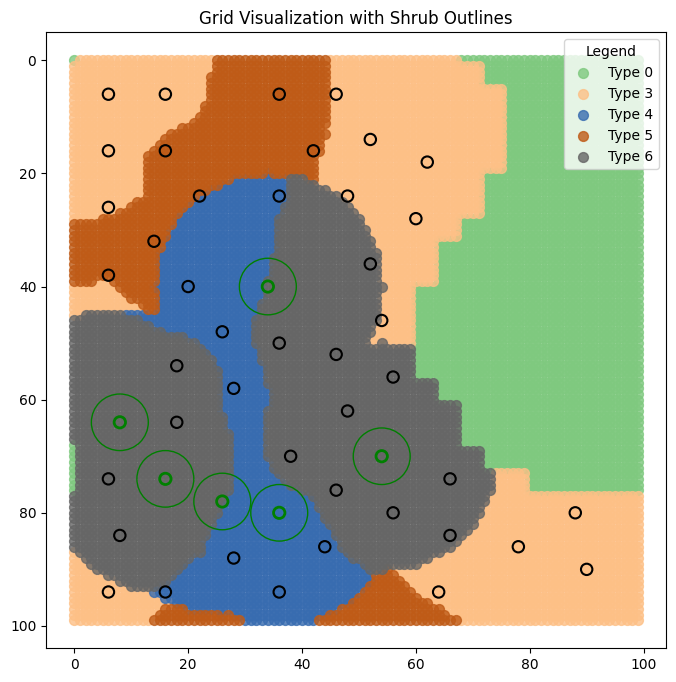

In [30]:
def initialise_grid():
    model = "./models/23rd.zip" # Model used for the grid Generation
    RNG_seed = None
    input_grid = createGrid(model_path=model, seed=RNG_seed)
    trees, seed_list = extract_tree_shrub_placements(input_grid)
    return input_grid, seed_list, trees

def combined(input_grid, seed_list, starter_seeds, threshold = 0.1, fall_off = False, visualise= False):
    working_grid, seed_locations = choose_starter_slots(input, seed_list, starter_seeds) # Check this function idk why it needs both a grid and the seed_list
    noise_map = generate_worley_heatmap()
    noise_grids = combined_noisemap(input_grid, noise_map,seed_locations)
    heatmaps = create_heatmaps(seed_locations,input_grid,noise_grids, fall_off)
    if visualise:
        for i in heatmaps:
            visualize_heatmap(heatmaps[i])
    output_grid = apply_influence_grids_with_border(heatmaps, input_grid, threshold=threshold)

    return output_grid

def postprocessing(intermediate_grid, seed_list):
    cleaned_grid = fill_small_regions(intermediate_grid, required_points=seed_locations)
    seed_dict = sort_seeds_v2(cleaned_grid, seed_list)
    return cleaned_grid, seed_dict


starter_seeds_x = [3,4,5,6] # To be created using a function
input_grid_x, seed_list_x, trees_x = initialise_grid() # Please replace with  wx version and check that it workes with wx legend ( )
intermediate_grid_x = combined(input_grid_x, seed_list_x, starter_seeds_x)
output_grid_x, seed_dict_x = postprocessing(intermediate_grid_x, seed_list_x)

print(seed_dict_x)
visualize_grid_with_outlines(output_grid_x, seed_dict_x,trees_x)


## Moving shrubs into the area while also ensuring that each spot has a seed

In [31]:
import numpy as np
import cv2

def shift_seeds_inward(input_grid, seed_dict_x, min_distance=7):
    """
    Shift seeds in `seed_dict_x` inward if they are too close to the boundary of their respective areas.

    Args:
        input_grid (np.ndarray): A numpy grid representing the different areas.
        seed_dict_x (dict): A dictionary with keys as area types and values as lists of (y, x) coordinates of seeds.
        min_distance (float): The minimum distance a seed must maintain from the boundary.

    Returns:
        dict: Updated seed_dict_x with seeds shifted inward where necessary.
    """
    # Iterate over each area type in the seed dictionary
    for area_type, seeds in seed_dict_x.items():
        # Create a binary mask for the current area type
        binary_mask = (input_grid == area_type).astype(np.uint8)
        
        # Apply distance transform to get distances from the boundary
        distance_to_boundary = cv2.distanceTransform(binary_mask, distanceType=cv2.DIST_L2, maskSize=5)

        # Shift each seed inward if it's too close to the boundary
        new_positions = []
        for seed in seeds:
            y, x = seed
            proximity = distance_to_boundary[y, x]
            
            if proximity < min_distance:
                # Seed is too close to the boundary, shift inward
                best_shift = None
                max_distance = 0

                # Check all 8 neighbours
                for dy, dx in [(-1, 0), (1, 0), (0, -1), (0, 1), (-1, -1), (-1, 1), (1, -1), (1, 1)]:
                    ny, nx = y + dy, x + dx
                    if 0 <= ny < input_grid.shape[0] and 0 <= nx < input_grid.shape[1]:
                        if input_grid[ny, nx] == area_type and distance_to_boundary[ny, nx] > max_distance:
                            max_distance = distance_to_boundary[ny, nx]
                            best_shift = (ny, nx)

                # If a better position is found, shift the seed
                if best_shift:
                    new_positions.append(best_shift)
                else:
                    # If no shift is possible, keep the original position
                    new_positions.append((y, x))
            else:
                # Seed is far enough from the boundary, no shift needed
                new_positions.append((y, x))
        
        # Update the seed positions in seed_dict_x
        seed_dict_x[area_type] = new_positions

    return seed_dict_x

def shift_and_space_seeds(input_grid, seed_dict_x, min_distance=7, spacing_distance=10):
    """
    Shift seeds inward if they are too close to the boundary of their respective areas,
    and ensure seeds are spaced out within each region as much as possible.

    Args:
        input_grid (np.ndarray): A numpy grid representing the different areas.
        seed_dict_x (dict): A dictionary with keys as area types and values as lists of (y, x) coordinates of seeds.
        min_distance (float): The minimum distance a seed must maintain from the boundary.
        spacing_distance (float): The minimum distance seeds must maintain from each other.

    Returns:
        dict: Updated seed_dict_x with seeds shifted inward and spaced out within regions.
    """
    for area_type, seeds in seed_dict_x.items():
        # Create a binary mask for the current area type
        binary_mask = (input_grid == area_type).astype(np.uint8)
        
        # Apply distance transform to get distances from the boundary
        distance_to_boundary = cv2.distanceTransform(binary_mask, distanceType=cv2.DIST_L2, maskSize=5)

        # Maintain a list of placed seeds
        placed_seeds = []

        for seed in seeds:
            y, x = seed
            proximity = distance_to_boundary[y, x]

            if proximity < min_distance:
                # Seed is too close to the boundary, shift inward
                best_shift = None
                max_distance = 0

                # Check all 8 neighbours
                for dy, dx in [(-1, 0), (1, 0), (0, -1), (0, 1), (-1, -1), (-1, 1), (1, -1), (1, 1)]:
                    ny, nx = y + dy, x + dx
                    if 0 <= ny < input_grid.shape[0] and 0 <= nx < input_grid.shape[1]:
                        if (
                            input_grid[ny, nx] == area_type
                            and distance_to_boundary[ny, nx] > max_distance
                        ):
                            max_distance = distance_to_boundary[ny, nx]
                            best_shift = (ny, nx)

                # If a better position is found, shift the seed
                if best_shift:
                    y, x = best_shift

            # Ensure the seed is spaced out from already placed seeds
            is_spaced = all(
                np.sqrt((y - py) ** 2 + (x - px) ** 2) >= spacing_distance
                for py, px in placed_seeds
            )

            if is_spaced:
                placed_seeds.append((y, x))

        # Update the seed positions in seed_dict_x
        seed_dict_x[area_type] = placed_seeds

    return seed_dict_x

def shift_and_space_seeds_2(input_grid, seed_dict_x, min_distance=5, spacing_distance=7):
    """
    Iteratively shift seeds inward until they are above the minimum distance from the boundary,
    and ensure seeds are spaced out within their respective regions.

    Args:
        input_grid (np.ndarray): A numpy grid representing the different areas.
        seed_dict_x (dict): A dictionary with keys as area types and values as lists of (y, x) coordinates of seeds.
        min_distance (float): The minimum distance a seed must maintain from the boundary.
        spacing_distance (float): The minimum distance seeds must maintain from each other.

    Returns:
        dict: Updated seed_dict_x with seeds shifted inward and spaced out within regions.
    """
    for area_type, seeds in seed_dict_x.items():
        # Create a binary mask for the current area type
        binary_mask = (input_grid == area_type).astype(np.uint8)

        # Apply distance transform to get distances from the boundary
        distance_to_boundary = cv2.distanceTransform(binary_mask, distanceType=cv2.DIST_L2, maskSize=5)

        # Step 1: Shift seeds inward until they meet the minimum distance from the boundary
        shifted_seeds = []
        for seed in seeds:
            y, x = seed
            steps = 0  # Timeout counter

            while distance_to_boundary[y, x] < min_distance and steps < min_distance:
                best_shift = None
                max_distance = 0

                # Check all 8 neighbors to find the best inward shift
                for dy, dx in [(-1, 0), (1, 0), (0, -1), (0, 1), (-1, -1), (-1, 1), (1, -1), (1, 1)]:
                    ny, nx = y + dy, x + dx
                    if 0 <= ny < input_grid.shape[0] and 0 <= nx < input_grid.shape[1]:
                        if (
                            input_grid[ny, nx] == area_type
                            and distance_to_boundary[ny, nx] > max_distance
                        ):
                            max_distance = distance_to_boundary[ny, nx]
                            best_shift = (ny, nx)

                # If a better position is found, shift the seed
                if best_shift:
                    y, x = best_shift
                else:
                    # If no valid shift is possible, stop the loop
                    break

                steps += 1  # Increment the timeout counter

            shifted_seeds.append((y, x))

        # Step 2: Check for spacing and adjust positions to avoid overlap
        placed_seeds = []
        for seed in shifted_seeds:
            y, x = seed

            # Ensure the seed is spaced out from already placed seeds
            while any(
                np.sqrt((y - py) ** 2 + (x - px) ** 2) < spacing_distance
                for py, px in placed_seeds
            ):
                best_shift = None
                max_distance = 0

                # Check all 8 neighbors to find the best shift to maintain spacing
                for dy, dx in [(-1, 0), (1, 0), (0, -1), (0, 1), (-1, -1), (-1, 1), (1, -1), (1, 1)]:
                    ny, nx = y + dy, x + dx
                    if 0 <= ny < input_grid.shape[0] and 0 <= nx < input_grid.shape[1]:
                        if input_grid[ny, nx] == area_type:
                            distance_to_all_placed = [
                                np.sqrt((ny - py) ** 2 + (nx - px) ** 2) for py, px in placed_seeds
                            ]
                            if all(d >= spacing_distance for d in distance_to_all_placed):
                                max_distance = distance_to_boundary[ny, nx]
                                best_shift = (ny, nx)

                # If a better position is found, shift the seed
                if best_shift:
                    y, x = best_shift
                else:
                    # If no valid shift is possible, stop adjusting
                    break

            placed_seeds.append((y, x))

        # Update the seed positions in seed_dict_x
        seed_dict_x[area_type] = placed_seeds

    return seed_dict_x


def shift_and_space_seeds_optimized(input_grid, seed_dict_x, min_distance=5, spacing_distance=7, max_iterations=100):
    """
    Optimized version to shift seeds inward and ensure they are spaced out within regions.
    Includes timeout for both boundary adjustment and spacing adjustments.

    Args:
        input_grid (np.ndarray): A numpy grid representing the different areas.
        seed_dict_x (dict): A dictionary with keys as area types and values as lists of (y, x) coordinates of seeds.
        min_distance (float): The minimum distance a seed must maintain from the boundary.
        spacing_distance (float): The minimum distance seeds must maintain from each other.
        max_iterations (int): Maximum number of iterations to try for adjusting seed spacing.

    Returns:
        dict: Updated seed_dict_x with seeds shifted inward and spaced out within regions.
    """
    for area_type, seeds in seed_dict_x.items():
        # Create a binary mask for the current area type
        binary_mask = (input_grid == area_type).astype(np.uint8)

        # Apply distance transform to get distances from the boundary
        distance_to_boundary = cv2.distanceTransform(binary_mask, distanceType=cv2.DIST_L2, maskSize=5)

        # Step 1: Shift seeds inward until they meet the minimum distance from the boundary
        shifted_seeds = []
        for seed in seeds:
            y, x = seed
            steps = 0  # Timeout counter for boundary adjustment

            while distance_to_boundary[y, x] < min_distance and steps < min_distance:
                best_shift = None
                max_distance = 0

                # Check all 8 neighbors to find the best inward shift
                for dy, dx in [(-1, 0), (1, 0), (0, -1), (0, 1), (-1, -1), (-1, 1), (1, -1), (1, 1)]:
                    ny, nx = y + dy, x + dx
                    if 0 <= ny < input_grid.shape[0] and 0 <= nx < input_grid.shape[1]:
                        if (
                            input_grid[ny, nx] == area_type
                            and distance_to_boundary[ny, nx] > max_distance
                        ):
                            max_distance = distance_to_boundary[ny, nx]
                            best_shift = (ny, nx)

                # If a better position is found, shift the seed
                if best_shift:
                    y, x = best_shift
                else:
                    # If no valid shift is possible, stop the loop
                    break

                steps += 1  # Increment the timeout counter

            shifted_seeds.append((y, x))

        # Step 2: Adjust seeds iteratively to improve spacing
        placed_seeds = []
        for seed in shifted_seeds:
            y, x = seed
            iterations = 0  # Timeout counter for spacing adjustment

            # Iterate to adjust until spacing is achieved or timeout is reached
            while iterations < max_iterations:
                is_spaced = all(
                    np.sqrt((y - py) ** 2 + (x - px) ** 2) >= spacing_distance
                    for py, px in placed_seeds
                )
                if is_spaced:
                    break

                best_shift = None
                max_spacing = 0

                # Check all 8 neighbors to find the best shift to improve spacing
                for dy, dx in [(-1, 0), (1, 0), (0, -1), (0, 1), (-1, -1), (-1, 1), (1, -1), (1, 1)]:
                    ny, nx = y + dy, x + dx
                    if 0 <= ny < input_grid.shape[0] and 0 <= nx < input_grid.shape[1]:
                        if input_grid[ny, nx] == area_type:
                            # Calculate the minimum distance to all placed seeds
                            distances = [
                                np.sqrt((ny - py) ** 2 + (nx - px) ** 2) for py, px in placed_seeds
                            ]
                            min_spacing = min(distances) if distances else float("inf")
                            if min_spacing > max_spacing:
                                max_spacing = min_spacing
                                best_shift = (ny, nx)

                # If a better position is found, shift the seed
                if best_shift:
                    y, x = best_shift
                else:
                    # If no valid shift is possible, stop adjusting
                    break

                iterations += 1  # Increment the timeout counter

            placed_seeds.append((y, x))

        # Update the seed positions in seed_dict_x
        seed_dict_x[area_type] = placed_seeds

    return seed_dict_x

Loaded model from ./models/23rd.zip
Episode finished after 502 steps


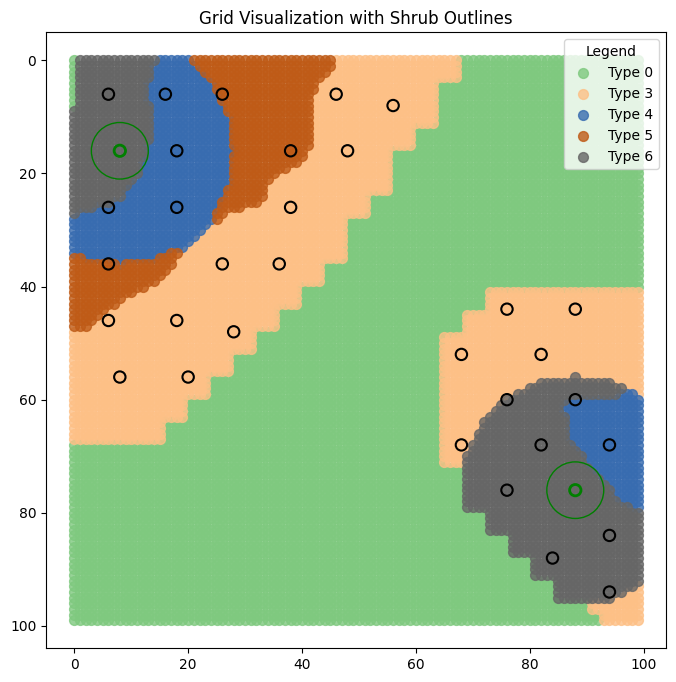

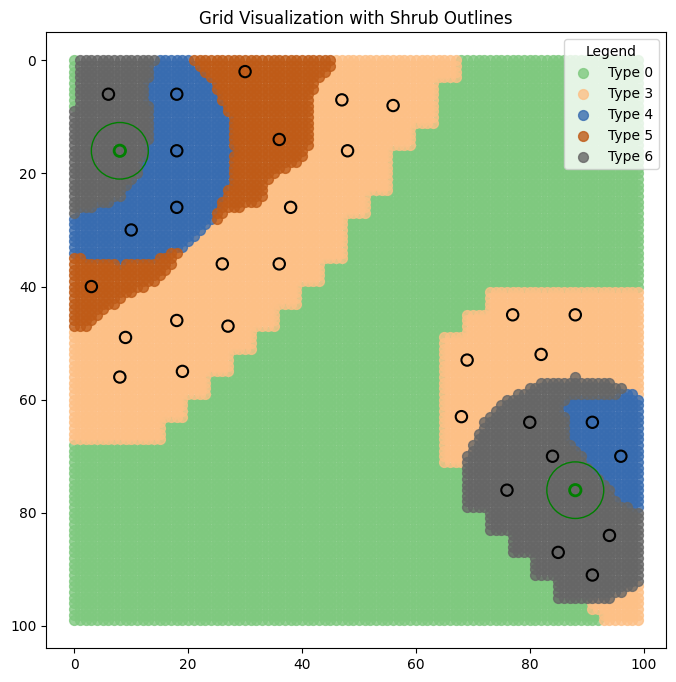

In [32]:
starter_seeds_x = [3,4,5,6] # To be created using a function
input_grid_x, seed_list_x, trees_x = initialise_grid() # Please replace with  wx version and check that it workes with wx legend ( )
intermediate_grid_x = combined(input_grid_x, seed_list_x, starter_seeds_x)
output_grid_x, seed_dict_x = postprocessing(intermediate_grid_x, seed_list_x)

visualize_grid_with_outlines(output_grid_x, seed_dict_x,trees_x)

# shifted_seeds = shift_seeds_inward(output_grid_x, seed_dict_x)
# visualize_grid_with_outlines(output_grid_x, shifted_seeds,trees_x)

# shifted_seeds_2 = shift_and_space_seeds(output_grid_x, seed_dict_x)
# visualize_grid_with_outlines(output_grid_x, shifted_seeds_2,trees_x)

# shifted_seeds_3 = shift_and_space_seeds_2(output_grid_x, seed_dict_x)
# visualize_grid_with_outlines(output_grid_x, shifted_seeds_3,trees_x)

shifted_seeds_3 = shift_and_space_seeds_optimized(output_grid_x, seed_dict_x)
visualize_grid_with_outlines(output_grid_x, shifted_seeds_3,trees_x)


In [33]:
import matplotlib.pyplot as plt
from scipy.ndimage import label
import numpy as np

def merge_regions_without_seeds(input_grid, seed_dict_x, visualise=False):
    """
    Merge regions without any seeds into neighboring regions, separating regions by boundaries and region types.

    Args:
        input_grid (np.ndarray): A numpy grid representing different regions by type.
        seed_dict_x (dict): A dictionary with keys as region types and values as lists of seed coordinates.

    Returns:
        np.ndarray: A modified grid where regions without seeds are merged into neighboring regions.
    """
    # Step 1: Label each type separately and assign unique labels
    labeled_grid = np.zeros_like(input_grid, dtype=int)
    current_label = 1  # Start labeling from 1
    region_type_to_labels = {}  # Keep track of which labels belong to which region type

    for region_type in np.unique(input_grid):
        if region_type == 0:  # Skip unplantable areas
            continue

        # Label regions for the current type
        type_mask = (input_grid == region_type).astype(int)
        labeled_type, num_features = label(type_mask)

        # Assign unique labels for this type
        for feature_id in range(1, num_features + 1):
            labeled_grid[labeled_type == feature_id] = current_label
            if region_type not in region_type_to_labels:
                region_type_to_labels[region_type] = []
            region_type_to_labels[region_type].append(current_label)
            current_label += 1

    if visualise == True:
        # Visualization after Step 1: Display labeled regions
        plt.figure(figsize=(8, 8))
        plt.imshow(labeled_grid, cmap="tab20", origin="upper")
        plt.colorbar(label="Region Label")
        for region_type, seeds in seed_dict_x.items():
            for y, x in seeds:
                plt.scatter(x, y, c="red", label=f"Type {region_type}" if y == seeds[0][0] else "", s=100, edgecolors="black")
        plt.title("Labeled Regions with Seeds")
        plt.xlabel("X-axis")
        plt.ylabel("Y-axis")
        plt.legend(loc="upper right", bbox_to_anchor=(1.3, 1))
        plt.show()

    # Step 2: Check regions for seeds
    regions_with_seeds = set()
    for region_type, seeds in seed_dict_x.items():
        for seed in seeds:
            y, x = seed
            region_label = labeled_grid[y, x]
            regions_with_seeds.add(region_label)

    # Step 3: Merge regions without seeds into neighboring regions
    for region_label in np.unique(labeled_grid):
        if region_label == 0 or region_label in regions_with_seeds:
            continue

        # Get coordinates of the seedless region
        region_coords = np.argwhere(labeled_grid == region_label)

        # Find neighboring regions
        neighbors = {}
        for y, x in region_coords:
            for dy, dx in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
                ny, nx = y + dy, x + dx
                if 0 <= ny < input_grid.shape[0] and 0 <= nx < input_grid.shape[1]:
                    neighbor_label = labeled_grid[ny, nx]
                    if neighbor_label > 0 and neighbor_label != region_label:
                        neighbors[neighbor_label] = neighbors.get(neighbor_label, 0) + 1

        # Merge into the most common neighboring region
        if neighbors:
            largest_neighbor = max(neighbors, key=neighbors.get)
            for y, x in region_coords:
                labeled_grid[y, x] = largest_neighbor

    # Step 4: Map back to original region types
    merged_grid = np.zeros_like(input_grid)
    for region_type, label_list in region_type_to_labels.items():
        for label_id in label_list:
            merged_grid[labeled_grid == label_id] = region_type

    return merged_grid


Loaded model from ./models/23rd.zip
Episode finished after 770 steps


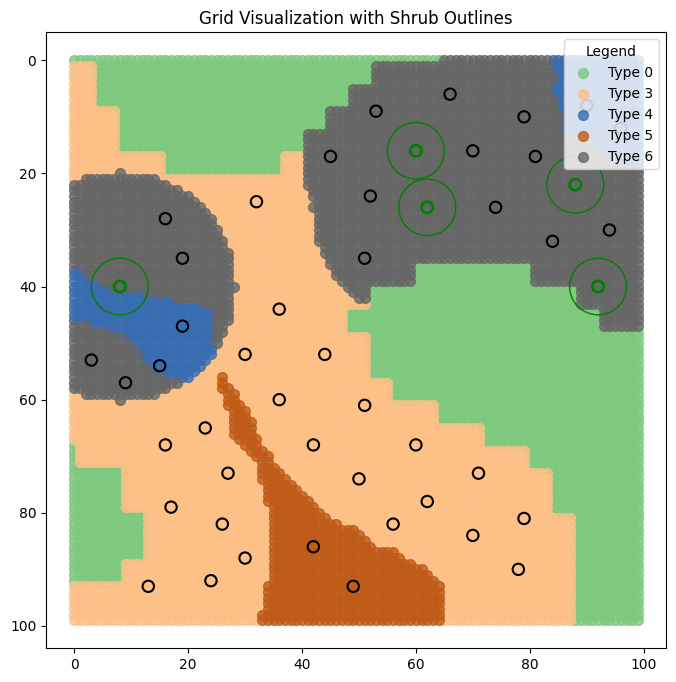

In [34]:
starter_seeds_x = [3,4,5,6] # To be created using a function
input_grid_x, seed_list_x, trees_x = initialise_grid() # Please replace with  wx version and check that it workes with wx legend ( )
intermediate_grid_x = combined(input_grid_x, seed_list_x, starter_seeds_x)
output_grid_x, seed_dict_x = postprocessing(intermediate_grid_x, seed_list_x)
shifted_seeds_3 = shift_and_space_seeds_optimized(output_grid_x, seed_dict_x)

# visualize_grid_with_outlines(output_grid_x, seed_dict_x,trees_x)

# visualize_grid_with_outlines(output_grid_x, shifted_seeds_3,trees_x)


new_grid_xx = merge_regions_without_seeds(output_grid_x,shifted_seeds_3)
visualize_grid_with_outlines(new_grid_xx, seed_dict_x,trees_x)


Loaded model from ./models/23rd.zip
Episode finished after 572 steps


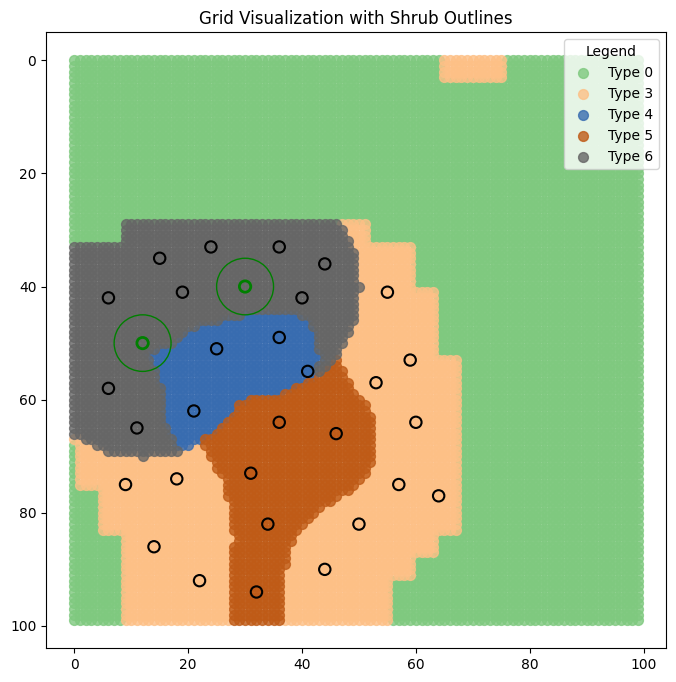

In [35]:
def initialise_grid():
    model = "./models/23rd.zip" # Model used for the grid Generation
    RNG_seed = None
    input_grid = createGrid(model_path=model, seed=RNG_seed)
    trees, seed_list = extract_tree_shrub_placements(input_grid)
    return input_grid, seed_list, trees

def combined(input_grid, seed_list, starter_seeds, threshold = 0.1, fall_off = False, visualise= False):
    working_grid, seed_locations = choose_starter_slots(input, seed_list, starter_seeds) # Check this function idk why it needs both a grid and the seed_list
    noise_map = generate_worley_heatmap()
    noise_grids = combined_noisemap(input_grid, noise_map,seed_locations)
    heatmaps = create_heatmaps(seed_locations,input_grid,noise_grids, fall_off)
    if visualise:
        for i in heatmaps:
            visualize_heatmap(heatmaps[i])
    output_grid = apply_influence_grids_with_border(heatmaps, input_grid, threshold=threshold)

    return output_grid

def postprocessing(intermediate_grid, seed_list):
    cleaned_grid = fill_small_regions(intermediate_grid, required_points=seed_locations)
    seed_dict = sort_seeds_v2(cleaned_grid, seed_list)
    shifted_seeds_dict = shift_and_space_seeds_optimized(cleaned_grid, seed_dict)
    cleaned_grid = merge_regions_without_seeds(cleaned_grid,shifted_seeds_dict)
    
    return cleaned_grid, seed_dict


starter_seeds_x = [3,4,5,6] # To be created using a function
input_grid_x, seed_list_x, trees_x = initialise_grid() # Please replace with  wx version and check that it workes with wx legend ( )
intermediate_grid_x = combined(input_grid_x, seed_list_x, starter_seeds_x)
output_grid_x, seed_dict_x = postprocessing(intermediate_grid_x, seed_list_x)

visualize_grid_with_outlines(output_grid_x, seed_dict_x,trees_x)


In [36]:
def choose_starter_slots_v2(shrub_positions, starter_types, percentage_of_starters=0.8):
    """
    Selects a percentage of shrub positions to be assigned as starter slots and groups them
    by starter types based on the provided list.

    Args:
        shrub_positions (list): List of tuples representing the positions of shrubs.
        starter_types (list): List of integers representing the types to assign.
        percentage_of_starters (float): Percentage of shrub positions to use as starter slots. Default is 0.8 (80%).

    Returns:
        dict: A dictionary of seed locations by type.
    """
    shrub_slots = copy.deepcopy(shrub_positions)
    seed_locations = {t: [] for t in starter_types}

    # Determine the number of starters based on the percentage
    number_of_starters = int(len(shrub_slots) * percentage_of_starters)
    number_of_starters = max(1, number_of_starters)  # Ensure at least one starter is selected

    # Use the provided list of starter types in sequence
    types_sequence = [starter_types[i % len(starter_types)] for i in range(number_of_starters)]

    for i, assigned_type in enumerate(types_sequence):
        if not shrub_slots:  # If no more shrub positions are left, break the loop
            break
        selected_position = shrub_slots.pop(0)  # Select the next shrub position in order
        seed_locations[assigned_type].append(selected_position)

    return seed_locations

Loaded model from ./models/23rd.zip
Episode finished after 537 steps


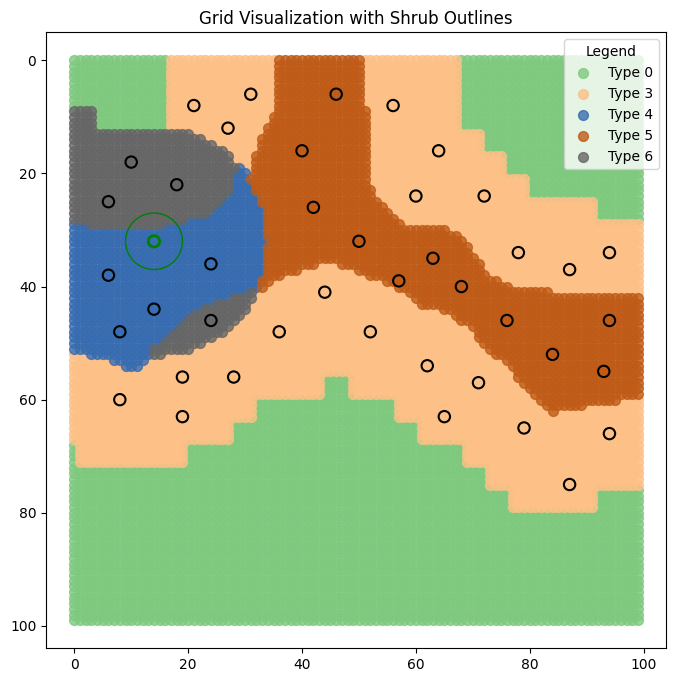

[(32, 14)]


In [37]:
def initialise_grid():
    model = "./models/23rd.zip" # Model used for the grid Generation
    RNG_seed = None
    input_grid = createGrid(model_path=model, seed=RNG_seed)
    trees, seed_list = extract_tree_shrub_placements(input_grid)
    return input_grid, seed_list, trees

def combined(input_grid, seed_list, starter_seeds, threshold = 0.1, fall_off = False, visualise= False):
    # One visualisatoin can be run on input grid
    seed_locations = choose_starter_slots_v2(seed_list, starter_seeds) 
    noise_map = generate_worley_heatmap()
    noise_grids = combined_noisemap(input_grid, noise_map,seed_locations)
    heatmaps = create_heatmaps(seed_locations,input_grid,noise_grids, fall_off)
    # Can visualise heatmaps with visualisation here, also remember that the heatmap has other values if report needs
    if visualise:
        for i in heatmaps:
            visualize_heatmap(heatmaps[i])
    output_grid = apply_influence_grids_with_border(heatmaps, input_grid, threshold=threshold)
    # Can visualise the generated grid here
    return output_grid

def postprocessing(intermediate_grid, seed_list):
    cleaned_grid = fill_small_regions(intermediate_grid, required_points=seed_locations)
    # Can visualise the cleaned grid removed of the tiny small regions here
    seed_dict = sort_seeds_v2(cleaned_grid, seed_list)
    shifted_seeds_dict = shift_and_space_seeds_optimized(cleaned_grid, seed_dict)
    cleaned_grid = merge_regions_without_seeds(cleaned_grid,shifted_seeds_dict)
    # Can visualise the cleaned grid removed of the zones without seeds here
    
    return cleaned_grid, seed_dict


starter_seeds_x = [3,4,5,6] # To be created using a function
input_grid_x, seed_list_x, trees_x = initialise_grid() # Please replace with  wx version and check that it workes with wx legend ( )
intermediate_grid_x = combined(input_grid_x, seed_list_x, starter_seeds_x)
output_grid_x, seed_dict_x = postprocessing(intermediate_grid_x, seed_list_x)

visualize_grid_with_outlines(output_grid_x, seed_dict_x,trees_x)
print(trees_x)


Create a function that allocates a plant species or radius to each tuple
{
     (6,46): ["name", "radius"],
     (22,18): ["name", "radius"]
     ....
}

Change the label heatmap function to take in a dictionary of tuple: radius and generate the heatmap accordingly

Things for the me of tmr,

- Check for regions without any seeds and either  delete the region or add a seed into the area 👌
- Add mirroring from jx side 👌
- Generate the seeds accordingg to the given dict of seeds
- Relabeling them with the plant name rather than the type area (tmr or today)

Things I have not addressed
- context
- compiled all into a singular class function, + - Make it into fit wx legend
- Tree radius based on dictioary

In [38]:
def mirror_grid(grid, shrubs_dict, trees, visualise=False):
    """
    Mirror the grid and associated elements (shrubs and trees) along an optimal axis.

    Args:
        grid (np.ndarray): The input grid to be mirrored.
        shrubs_dict (dict): Dictionary of shrub positions by type.
        trees (list): List of tuples representing tree coordinates.
        visualise (bool): Whether to visualize the results.

    Returns:
        tuple: The mirrored grid, updated shrubs dictionary, updated tree list, and optimal split type.
    """
    # Step 2: Ensure grid is integer type
    grid = grid.astype(int)

    # Step 3: Define plantable values
    unique_values = np.unique(grid)
    plantable_values = {v for v in unique_values if v != 0}  # All non-zero values are plantable

    # Step 4: Detect edges
    edges = detect_edges_on_grid(grid, method="canny")
    if visualise:
        print("Plantable Values:", plantable_values)
        plt.imshow(edges, cmap="gray")
        plt.title("Edge Detection (Canny)")
        plt.show()

    # Step 5: Detect the optimal split and mirror the grid
    optimal_grid, optimal_shrubs_dict, optimal_split = detect_optimal_split_plantable(
        grid, shrubs_dict, edges, plantable_values
    )

    # Step 6: Mirror the trees across the split axis
    height, width = grid.shape
    mirrored_trees = set(trees)  # Use a set to avoid duplication

    if optimal_split == "horizontal":
        for y, x in trees:
            if y < height // 2:  # Top half
                mirrored_y = height - 1 - y
                mirrored_trees.add((mirrored_y, x))

    elif optimal_split == "vertical":
        for y, x in trees:
            if x < width // 2:  # Left half
                mirrored_x = width - 1 - x
                mirrored_trees.add((y, mirrored_x))

    elif optimal_split == "right_diagonal":
        for y, x in trees:
            if y + x >= width:  # Bottom-left triangle
                mirrored_y, mirrored_x = width - 1 - x, height - 1 - y
                mirrored_trees.add((mirrored_y, mirrored_x))

    elif optimal_split == "left_diagonal":
        for y, x in trees:
            if x < y:  # Bottom-right triangle
                mirrored_y, mirrored_x = x, y
                mirrored_trees.add((mirrored_y, mirrored_x))

    mirrored_trees = list(mirrored_trees)  # Convert back to list

    if visualise:
        print(f"The optimal split type detected was: {optimal_split}")

        # Visualize the original and mirrored grids
        visualize_grid_with_types(grid)
        visualize_grid_with_outlines(grid, shrubs_dict)
        visualize_grid_with_outlines(optimal_grid, optimal_shrubs_dict)

        # Visualize tree positions
        original_tree_grid = np.zeros_like(grid)
        for y, x in trees:
            original_tree_grid[y, x] = 1
        plt.figure()
        plt.imshow(original_tree_grid, cmap="gray")
        plt.title("Original Tree Positions")
        plt.show()

        mirrored_tree_grid = np.zeros_like(optimal_grid)
        for y, x in mirrored_trees:
            mirrored_tree_grid[y, x] = 1
        plt.figure()
        plt.imshow(mirrored_tree_grid, cmap="gray")
        plt.title("Mirrored Tree Positions")
        plt.show()

    return optimal_grid, optimal_shrubs_dict, mirrored_trees, optimal_split


def split_and_mirror_grid(grid, shrubs_dict, split_type="horizontal"):
    """
    Correctly split the grid into two parts, mirror one part to the other, 
    and return the updated grid and updated shrubs_dict.
    """
    height, width = grid.shape
    updated_shrubs_dict = {k: set() for k in shrubs_dict.keys()}  # Use sets to prevent duplication

    # Create a copy of the grid to prevent overwriting the mirrored section during processing
    mirrored_grid = grid.copy()

    if split_type == "horizontal":
        # Mirror top half to the bottom half
        top_half = grid[:height // 2, :]
        mirrored_grid[height // 2:, :] = np.flipud(top_half)

        # Update shrub positions
        for shrub_type, positions in shrubs_dict.items():
            for y, x in positions:
                if y < height // 2:  # Top half
                    updated_shrubs_dict[shrub_type].add((y, x))  # Keep original
                    mirrored_y = height - 1 - y
                    updated_shrubs_dict[shrub_type].add((mirrored_y, x))

    elif split_type == "vertical":
        # Mirror left half to the right half
        left_half = grid[:, :width // 2]
        mirrored_grid[:, width // 2:] = np.fliplr(left_half)

        # Update shrub positions
        for shrub_type, positions in shrubs_dict.items():
            for y, x in positions:
                if x < width // 2:  # Left half
                    updated_shrubs_dict[shrub_type].add((y, x))  # Keep original
                    mirrored_x = width - 1 - x
                    updated_shrubs_dict[shrub_type].add((y, mirrored_x))

    elif split_type == "right_diagonal":
        # Mirror bottom-left triangle to top-right triangle
        for i in range(height):
            for j in range(width):
                if i + j >= width:  # Bottom-left triangle
                    mirrored_grid[width - 1 - j, height - 1 - i] = grid[i, j]

        # Update shrub positions
        for shrub_type, positions in shrubs_dict.items():
            for y, x in positions:
                if y + x >= width:  # Bottom-left triangle
                    updated_shrubs_dict[shrub_type].add((y, x))
                    mirrored_y, mirrored_x = width - 1 - x, height - 1 - y
                    updated_shrubs_dict[shrub_type].add((mirrored_y, mirrored_x))

    elif split_type == "left_diagonal":
        # Mirror bottom-right triangle to top-left triangle
        for i in range(height):
            for j in range(width):
                if j < i:  # Bottom-right triangle
                    mirrored_grid[j, i] = grid[i, j]

        # Update shrub positions
        for shrub_type, positions in shrubs_dict.items():
            for y, x in positions:
                if x < y:  # Bottom-right triangle
                    updated_shrubs_dict[shrub_type].add((y, x))
                    mirrored_y, mirrored_x = x, y
                    updated_shrubs_dict[shrub_type].add((mirrored_y, mirrored_x))

    else:
        raise ValueError("Invalid split_type. Choose 'horizontal', 'vertical', 'right_diagonal', or 'left_diagonal'.")

    # Convert sets back to lists for compatibility
    for shrub_type in updated_shrubs_dict:
        updated_shrubs_dict[shrub_type] = list(updated_shrubs_dict[shrub_type])

    return mirrored_grid, updated_shrubs_dict, split_type

def detect_edges_on_grid(grid, method='canny', thresholds=(100, 200)):
    """
    Detect edges in a grid using Canny or Sobel methods.

    Args:
        grid (np.ndarray): The input grid to detect edges in.
        method (str): Edge detection method ('canny' or 'sobel').
        thresholds (tuple): Threshold values for the Canny edge detector.

    Returns:
        np.ndarray: A binary grid representing detected edges.
    """
    # Normalize the grid to 0-255 for edge detection
    normalized_grid = ((grid - grid.min()) / (grid.max() - grid.min()) * 255).astype(np.uint8)
    
    if method == 'canny':
        # Use Canny edge detection
        edges = cv2.Canny(normalized_grid, thresholds[0], thresholds[1])
    elif method == 'sobel':
        # Use Sobel edge detection
        sobelx = cv2.Sobel(normalized_grid, cv2.CV_64F, 1, 0, ksize=3)
        sobely = cv2.Sobel(normalized_grid, cv2.CV_64F, 0, 1, ksize=3)
        edges = (np.hypot(sobelx, sobely) > np.percentile(np.hypot(sobelx, sobely), 90)).astype(np.uint8)
    else:
        raise ValueError("Invalid method. Choose 'canny' or 'sobel'.")
    
    return edges




def evaluate_split_plantable(grid, mirrored_grid, edges, split_type, plantable_values, visualise=False):
    """
    Evaluate the symmetry of plantable areas, non-plantable areas, and edges in the mirrored grid.
    """
    height, width = grid.shape
    mirrored_edges = edges.copy()

    # Adjust edge mirroring
    if split_type == "horizontal":
        mirrored_edges = np.flipud(edges)
    elif split_type == "vertical":
        mirrored_edges = np.fliplr(edges)
    elif split_type == "right_diagonal":
        mirrored_edges = np.fliplr(np.flipud(edges))
    elif split_type == "left_diagonal":
        mirrored_edges = np.transpose(edges)

    # Create plantable masks
    plantable_mask = np.isin(grid, list(plantable_values))
    mirrored_plantable_mask = np.isin(mirrored_grid, list(plantable_values))

    # Calculate differences directly for plantable areas
    plantable_diff = np.sum(grid[plantable_mask] != mirrored_grid[plantable_mask])
    normalized_plantable_diff = plantable_diff / np.prod(grid.shape)  # Normalize by grid size

    # Edge differences
    edge_diff = np.sum((edges > 0) != (mirrored_edges > 0))
    normalized_edge_diff = edge_diff / np.sum(edges > 0) if np.sum(edges > 0) > 0 else 0

    # Apply weights
    plantable_weight = 0.7
    edge_weight = 0.3
    symmetry_score = -(
        plantable_weight * normalized_plantable_diff + edge_weight * normalized_edge_diff
    )

    if visualise:
        # Debugging visuals
        print(f"Split Type: {split_type}")
        print(f"Plantable Diff (Raw): {plantable_diff}, Normalized: {normalized_plantable_diff:.4f}")
        print(f"Edge Diff (Raw): {edge_diff}, Normalized: {normalized_edge_diff:.4f}")
        print(f"Weighted Symmetry Score: {symmetry_score:.4f}")

        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.imshow(grid, cmap='viridis')
        plt.title(f"Original Grid ({split_type})")
        plt.subplot(1, 2, 2)
        plt.imshow(mirrored_grid, cmap='viridis')
        plt.title(f"Mirrored Grid ({split_type})")
        plt.show()

    return symmetry_score




def detect_optimal_split_plantable(grid, shrubs_dict, edges, plantable_values, visualise= False):
    """
    Detect the optimal split for plantable areas in the grid.
    """
    results = {}
    shrubs_results = {}
    mirrored_grids = {}  # Store mirrored grids for each split type

    for split_type in ["horizontal", "vertical", "right_diagonal", "left_diagonal"]:
        temp_grid = grid.copy()
        mirrored_grid, mirrored_shrubs, _ = split_and_mirror_grid(temp_grid, shrubs_dict, split_type)
        score = evaluate_split_plantable(grid, mirrored_grid, edges, split_type, plantable_values, visualise=visualise)
        results[split_type] = score
        shrubs_results[split_type] = mirrored_shrubs
        mirrored_grids[split_type] = mirrored_grid  # Save the mirrored grid

    optimal_split = max(results, key=results.get)
    optimal_mirrored_grid = mirrored_grids[optimal_split]  # Retrieve the best mirrored grid

    if visualise:
        # Print the final optimal split
        print(f"Final Optimal Split: {optimal_split}")
        print(f"Optimal Symmetry Score: {results[optimal_split]:.4f}")
    
    return optimal_mirrored_grid, shrubs_results[optimal_split], optimal_split


In [39]:
mirrored_grid_x, seed_dict_mirrored_x, mirrored_trees_x, optimal_split = mirror_grid(output_grid_x,seed_dict_x, trees_x)

print(optimal_split)

horizontal


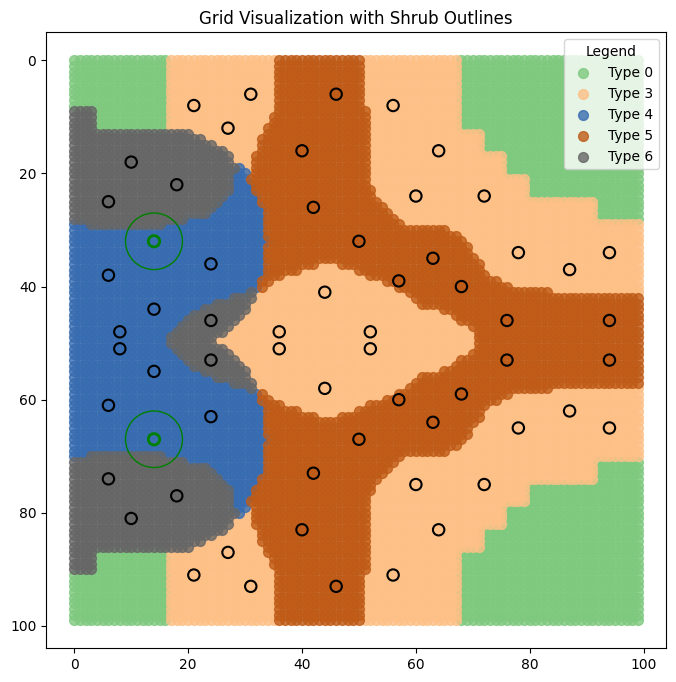

In [40]:
visualize_grid_with_outlines(mirrored_grid_x, seed_dict_mirrored_x,mirrored_trees_x)


Assuming dictionary of shrubs for input

In [41]:
# example dictionary
# only going to fake the plant_type, shade, fauna_attracting, hazardous, canopy_radius

## Theoretically, I should be accounting for water preference also
dict_of_plant_from_wx_part = {
    "selected_plants": [
        {
            "Plant Type": "Herbaceous Plant, Shrub",
            "Light Preference": "Full Shade, Semi Shade",
            "Attracted Animals": "Bee-Attracting",
            "Hazard": "-",
            "Canopy Radius": "None",
            "Species Name": "Bird's Nest Fern"
        },
        {
            "Plant Type": "Herbaceous Plant, Shrub",
            "Light Preference": "Full Shade, Semi Shade",
            "Attracted Animals": "-",
            "Hazard": "Toxic Upon Ingestion",
            "Canopy Radius": "None",
            "Species Name": "Horse Cassia"
        },
        {
            "Plant Type": "Herbaceous Plant, Tree",
            "Light Preference": "Full Shade, Semi Shade",
            "Attracted Animals": "-",
            "Hazard": "Toxic Upon Ingestion",
            "Canopy Radius": "19",
            "Species Name": "Seashore Ardisia"
        },
        {
            "Plant Type": "Palm",
            "Light Preference": "Full Shade, Semi Shade",
            "Attracted Animals": "-",
            "Hazard": "-",
            "Canopy Radius": "10",
            "Species Name": "Fishtail Palm"
        }
    ],
    "theme": "naturalistic"
}


In [42]:
##  Analyse and form the list of plants to be created based on the dictionary

import re

def contains_shrub(string):
    """
    Check if the string contains the word 'Shrub' (case-insensitive).
    Args:
        string (str): The input string to check.
    Returns:
        bool: True if the string contains 'Shrub', False otherwise.
    """
    return bool(re.search(r'\bShrub\b', string, re.IGNORECASE))

def contains_tree(string):
    """
    Check if the string contains the word 'Tree' (case-insensitive).
    Args:
        string (str): The input string to check.
    Returns:
        bool: True if the string contains 'Tree', False otherwise.
    """
    return bool(re.search(r'\bTree\b', string, re.IGNORECASE))

def contains_palm(string):
    """
    Check if the string contains the word 'Fern' (case-insensitive).
    Args:
        string (str): The input string to check.
    Returns:
        bool: True if the string contains 'Fern', False otherwise.
    """
    return bool(re.search(r'\bPalm\b', string, re.IGNORECASE))

def create_seed_pack(input_dict):
    Tree_Species = []
    Shrub_Species = []
    selected_plants_list = input_dict["selected_plants"]
    for plant in selected_plants_list:
        if contains_palm(plant["Plant Type"]) or contains_tree(plant["Plant Type"]):
            # It is a tree
            Tree_Species.append(plant)
        elif contains_shrub(plant["Plant Type"]):
            Shrub_Species.append(plant)
        else:
            print("WHATT ARE THOSEE")
            continue
    return Tree_Species,Shrub_Species

Trees_list, shrubs_list = create_seed_pack(dict_of_plant_from_wx_part)
print(Trees_list)
print(shrubs_list)

[{'Plant Type': 'Herbaceous Plant, Tree', 'Light Preference': 'Full Shade, Semi Shade', 'Attracted Animals': '-', 'Hazard': 'Toxic Upon Ingestion', 'Canopy Radius': '19', 'Species Name': 'Seashore Ardisia'}, {'Plant Type': 'Palm', 'Light Preference': 'Full Shade, Semi Shade', 'Attracted Animals': '-', 'Hazard': '-', 'Canopy Radius': '10', 'Species Name': 'Fishtail Palm'}]
[{'Plant Type': 'Herbaceous Plant, Shrub', 'Light Preference': 'Full Shade, Semi Shade', 'Attracted Animals': 'Bee-Attracting', 'Hazard': '-', 'Canopy Radius': 'None', 'Species Name': "Bird's Nest Fern"}, {'Plant Type': 'Herbaceous Plant, Shrub', 'Light Preference': 'Full Shade, Semi Shade', 'Attracted Animals': '-', 'Hazard': 'Toxic Upon Ingestion', 'Canopy Radius': 'None', 'Species Name': 'Horse Cassia'}]
